# Time-Series with ARIMA and LSTM

### Goal

Forecast the number and types of disasters for upcoming months/years to support disaster management planning.

Download the [dataset here](https://www.kaggle.com/datasets/fema/federal-disasters/data).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

## Load Data

In [2]:
df = pd.read_csv("../data/database.csv")
df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [3]:
df.shape

(46185, 14)

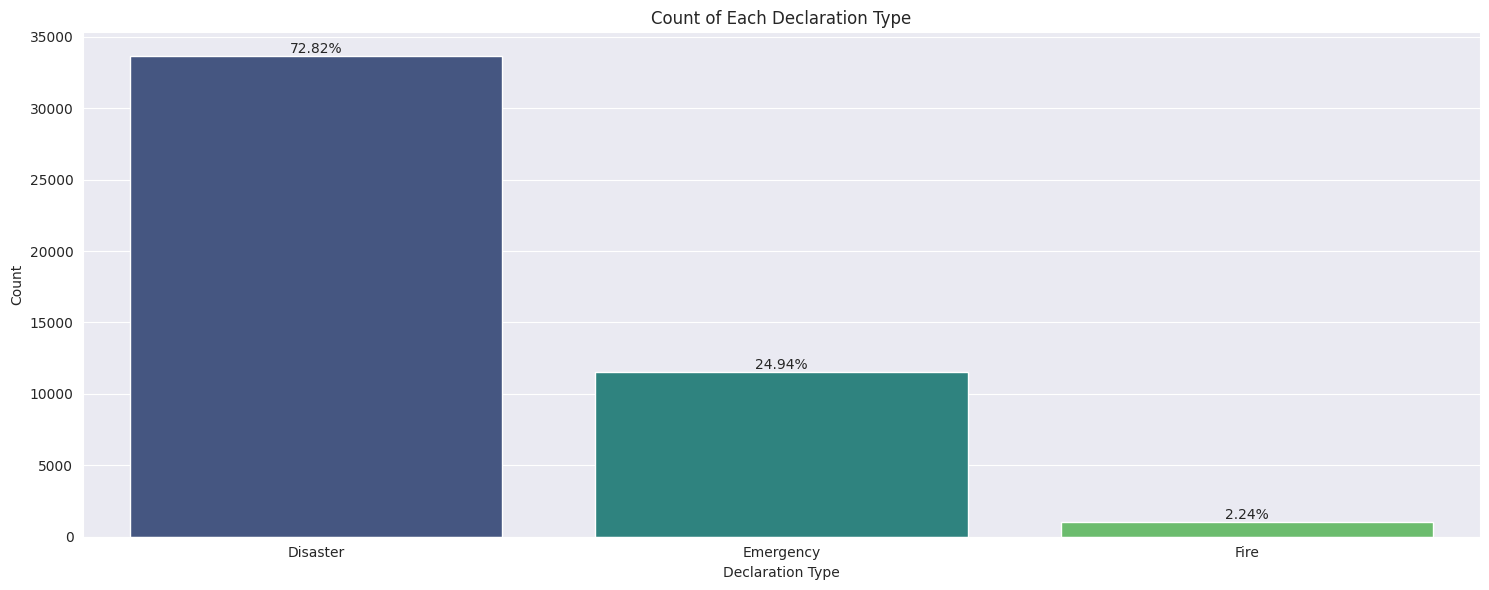

In [4]:
declaration_type_counts = df['Declaration Type'].value_counts()

total_count = declaration_type_counts.sum()
percentages = (declaration_type_counts / total_count) * 100

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=declaration_type_counts.index, y=declaration_type_counts.values, hue=declaration_type_counts.index, palette='viridis')
plt.xlabel('Declaration Type')
plt.ylabel('Count')
plt.title('Count of Each Declaration Type')

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout();


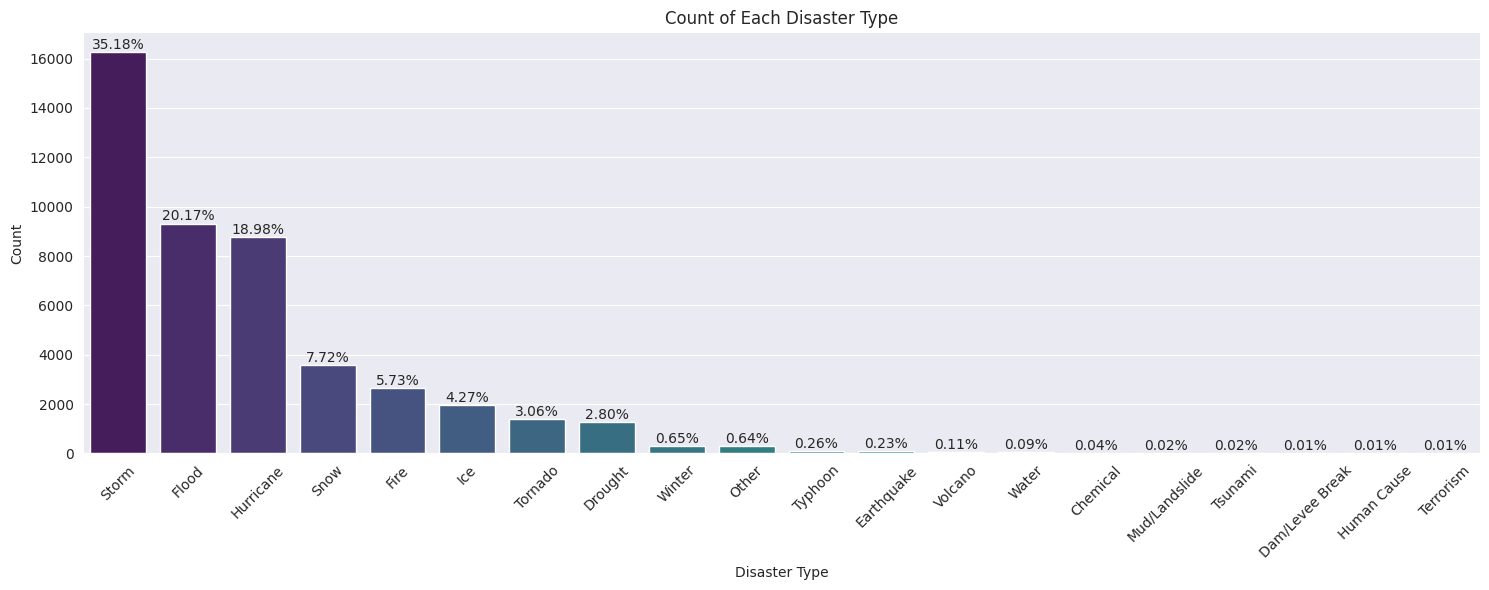

In [5]:
disaster_type_counts = df['Disaster Type'].value_counts()

total_count = disaster_type_counts.sum()
percentages = (disaster_type_counts / total_count) * 100

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=disaster_type_counts.index, y=disaster_type_counts.values, hue=disaster_type_counts.index, palette='viridis')
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Count of Each Disaster Type')

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.tight_layout();

In [6]:
df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

df['Timestamp'] = df['Declaration Date']

# Aggregate the data to count the total disasters per date
count_df = df.groupby('Timestamp').agg(
    Total_Disasters=('Declaration Type', 'count')
).reset_index()

count_df.set_index('Timestamp', inplace=True)

# Resample the time series to daily frequency and drop missing days
daily_ts_data = count_df['Total_Disasters'].asfreq('D').dropna()


In [7]:
daily_ts_data.head()

Timestamp
1953-05-02    1.0
1953-05-15    1.0
1953-05-29    1.0
1953-06-02    1.0
1953-06-06    1.0
Name: Total_Disasters, dtype: float64

In [8]:
daily_ts_data.isna().sum()

0

In [9]:
daily_ts_data.dtype

dtype('float64')

In [10]:
daily_ts_data.describe()

count    2507.000000
mean       18.422417
std        39.371001
min         1.000000
25%         2.000000
50%         6.000000
75%        20.000000
max       777.000000
Name: Total_Disasters, dtype: float64

In [11]:
strictly_increasing = daily_ts_data.is_monotonic_increasing
print(strictly_increasing)

False


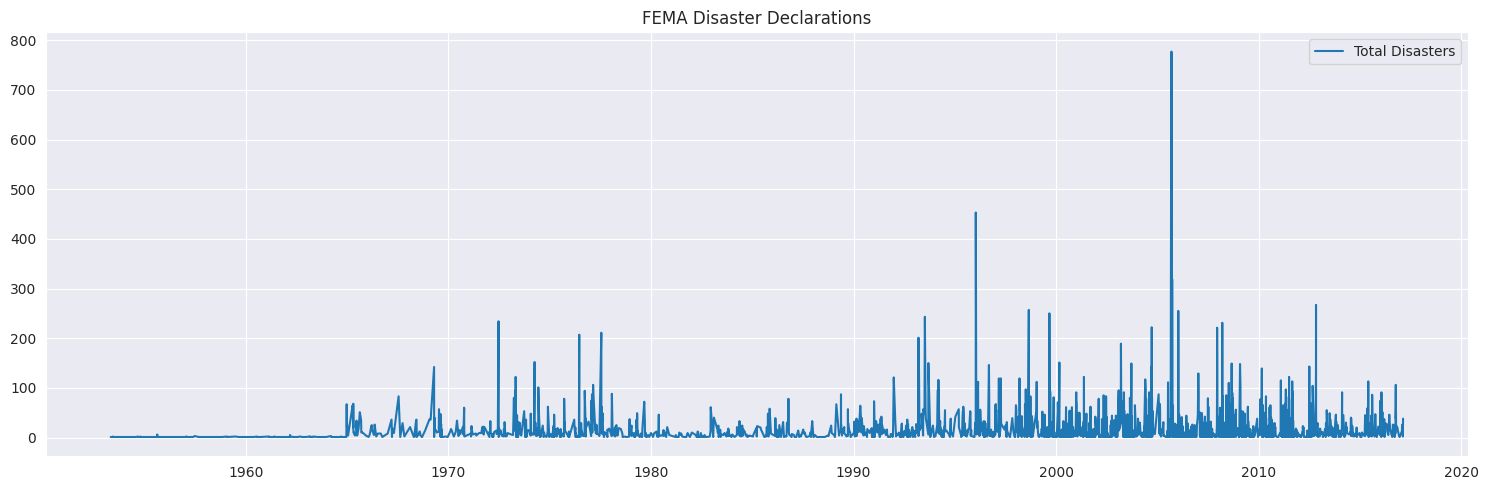

In [12]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(daily_ts_data, label='Total Disasters')
plt.title('FEMA Disaster Declarations')
plt.legend()
plt.tight_layout();

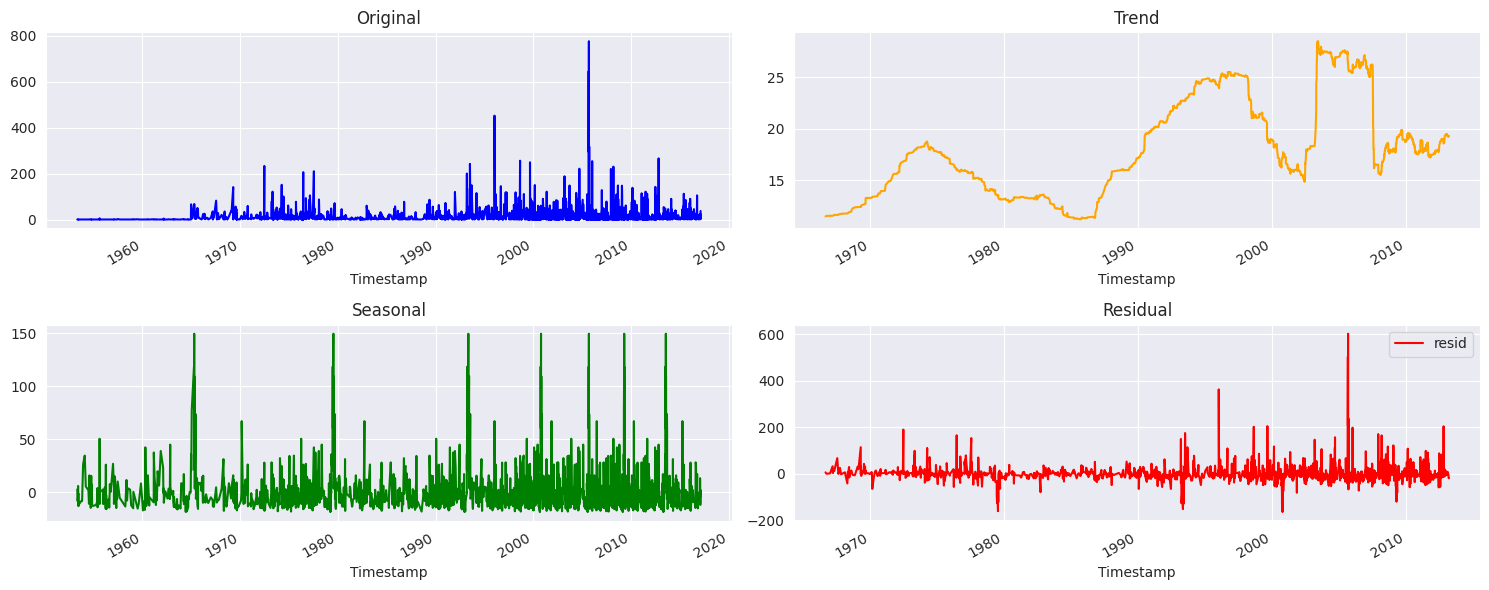

In [13]:
# Decompose
decomposition = sm.tsa.seasonal_decompose(daily_ts_data, model='additive', period=365)


fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot each component in a separate subplot
decomposition.observed.plot(ax=axes[0, 0], title='Original', color='blue')
decomposition.trend.plot(ax=axes[0, 1], title='Trend', color='orange')
decomposition.seasonal.plot(ax=axes[1, 0], title='Seasonal', color='green')
decomposition.resid.plot(ax=axes[1, 1], title='Residual', color='red')

plt.legend()
plt.tight_layout();

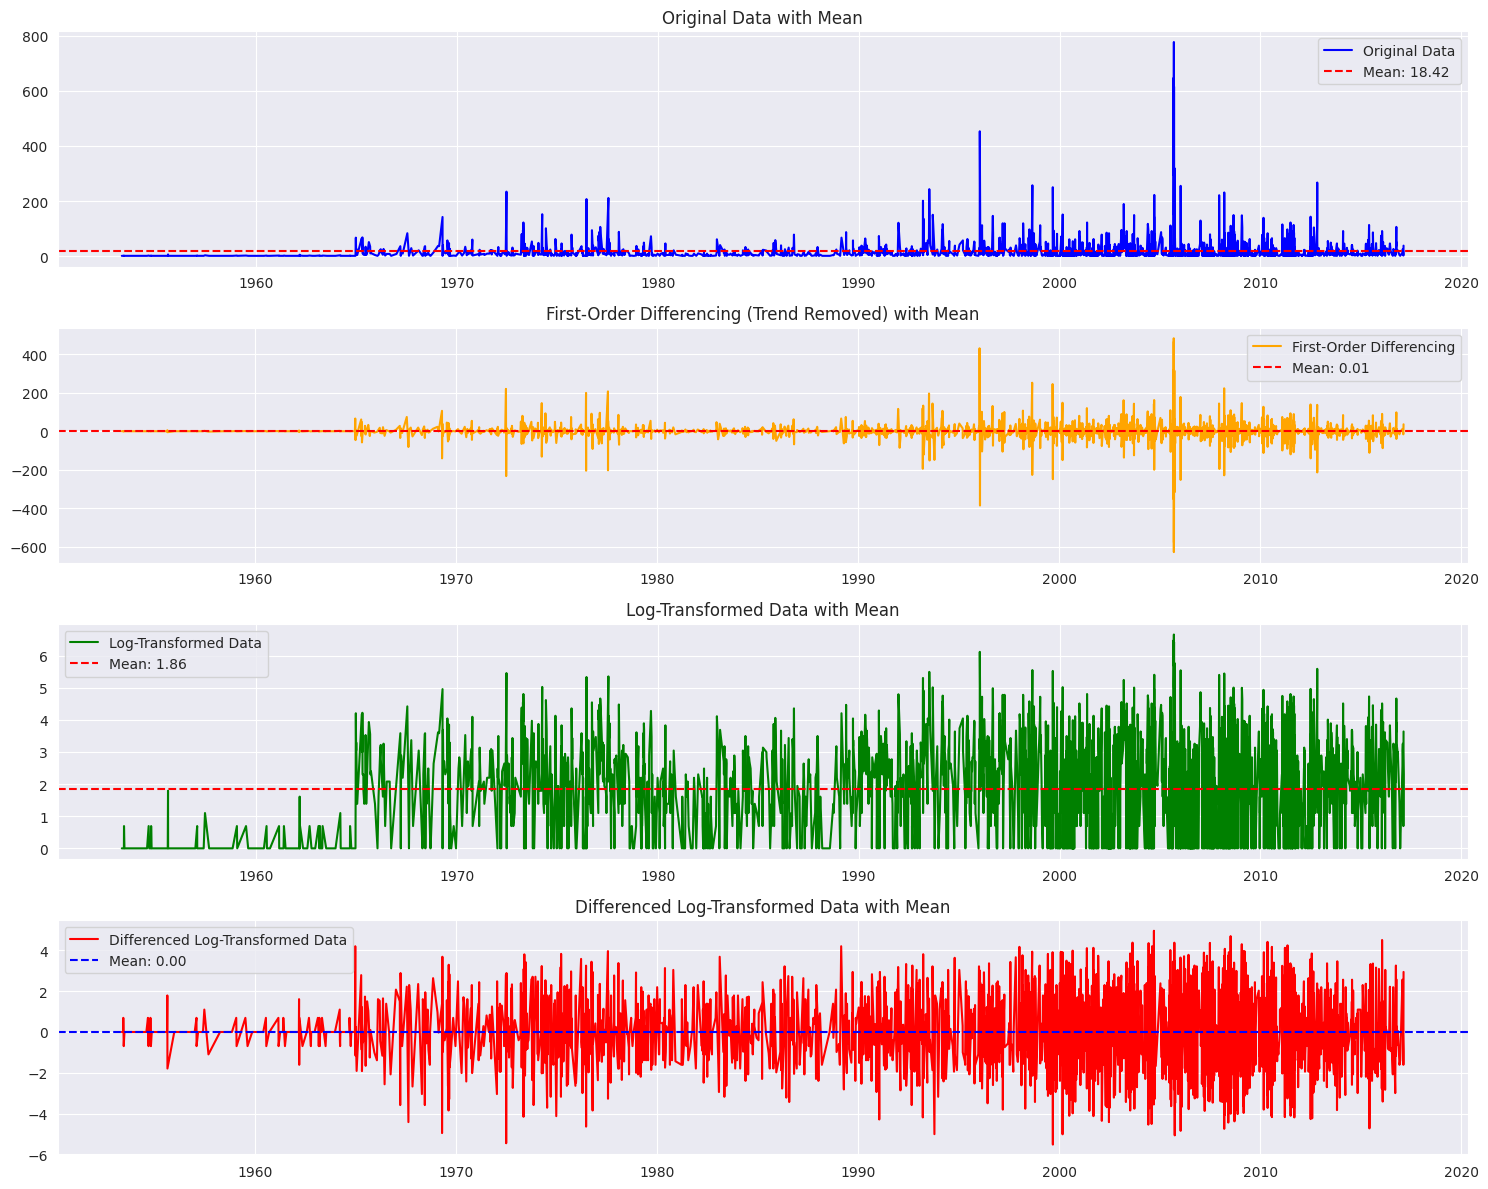

In [14]:
first_differenced = daily_ts_data.diff().dropna() # First Differenced Data

second_differenced = first_differenced.diff().dropna() # Second Differenced Data

log_transformed = np.log(daily_ts_data + 1e-5).replace(-np.inf, np.nan).dropna() # Log-Transformed Data

log_diff = log_transformed.diff().dropna() # Differenced Log-Transformed Data

# Calculate means for each transformation
original_mean = daily_ts_data.mean()
first_differenced_mean = first_differenced.mean()
second_differenced_mean = second_differenced.mean()
log_transformed_mean = log_transformed.mean()
log_diff_mean = log_diff.mean()

# Plot the Original Data with mean
plt.figure(figsize=(15, 12))
plt.subplot(4, 1, 1)
plt.plot(daily_ts_data, label="Original Data", color='blue')
plt.axhline(original_mean, color='red', linestyle='--', label=f"Mean: {original_mean:.2f}")
plt.title("Original Data with Mean")
plt.legend()

# Plot the First Differenced Data with mean
plt.subplot(4, 1, 2)
plt.plot(first_differenced, label="First-Order Differencing", color='orange')
plt.axhline(first_differenced_mean, color='red', linestyle='--', label=f"Mean: {first_differenced_mean:.2f}")
plt.title("First-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Log-Transformed Data with mean
plt.subplot(4, 1, 3)
plt.plot(log_transformed, label="Log-Transformed Data", color='green')
plt.axhline(log_transformed_mean, color='red', linestyle='--', label=f"Mean: {log_transformed_mean:.2f}")
plt.title("Log-Transformed Data with Mean")
plt.legend()  

# Plot the Differenced Log-Transformed Data with mean
plt.subplot(4, 1, 4)
plt.plot(log_diff, label="Differenced Log-Transformed Data", color='red')
plt.axhline(log_diff_mean, color='blue', linestyle='--', label=f"Mean: {log_diff_mean:.2f}")
plt.title("Differenced Log-Transformed Data with Mean")
plt.legend()

plt.tight_layout();

### Stationary Check

#### Which Test Should We Choose: ADF or KPSS?

Choosing between the ADF and KPSS tests can sometimes be confusing. A practical approach is to apply both tests and cross-check their conclusions to confirm if the series is truly stationary. The following outcomes can help interpret the results:
- **Case 1:** Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2:** Both tests conclude that the series is stationary - The series is stationary
- **Case 3:** KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [15]:
# ADF Test
def adf_test(timeseries):
    print("ADF Test:\n")
    print("Null Hypothesis (H0): The series has a unit root or is non-stationary.")
    print("Alternate Hypothesis (H1): The series has no unit root or is stationary.\n")
    print("Results of Dickey-Fuller Test:\n")
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(
        adf_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "Observations Used"]
    )
    for key, value in adf_result[4].items():
        adf_output[f"Critical Value ({key})"] = value
    print(adf_output,'\n')
    
    if adf_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is stationary.\n")
    else:
        print("Fail to Reject H0: The series is non-stationary.\n")
        

# KPSS Test
def kpss_test(timeseries):
    print("KPSS Test:\n")
    print("Null Hypothesis (H0): The series is trend stationary or has no unit root.")
    print("Alternate Hypothesis (H1): The series has a unit root (is non-stationary).\n")
    print("Results of KPSS Test:\n")
    kpss_result = kpss(timeseries, nlags="auto")
    kpss_output = pd.Series(
        kpss_result[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_result[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output,'\n')
    
    if kpss_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is non-stationary.\n")
    else:
        print("Fail to Reject H0: The series is stationary.\n")


In [16]:
# Check stationarity with ADF Test
adf_test(daily_ts_data) 

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.603150e+01
p-value                 6.050222e-29
Lags Used               3.000000e+00
Observations Used       2.503000e+03
Critical Value (1%)    -3.432965e+00
Critical Value (5%)    -2.862695e+00
Critical Value (10%)   -2.567385e+00
dtype: float64 

Reject H0: The series is stationary.



In [17]:
# Check stationarity with KPSS Test
kpss_test(daily_ts_data)

KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.384710
p-value                   0.083746
Lags Used                23.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 

Fail to Reject H0: The series is stationary.



Check Stationarity with ADF and KPSS Tests:

- **Based on the ADF Test, the series is stationary** because the p-value is less than the significance level of 0.05, leading to the rejection of the null hypothesis.
- **Based on the KPSS Test, the series is stationary** because the p-value is greater than the significance level of 0.05, leading to the failure to reject the null hypothesis.
- **Conclusion: The series is stationary.**

In [18]:
def diff_inv(series_diff, first_value):
    return np.cumsum(np.insert(series_diff, 0, first_value))


# Example of original series
original_series = pd.Series([100, 102, 105, 110, 115])

# Apply differentiation
series_diff = original_series.diff().dropna()

# Invert differentiation
first_value = original_series.iloc[0]
reconstructed_series = diff_inv(series_diff, first_value)

print("Original series:", original_series.values)
print("Differentiation series", series_diff)
print("Reconstructed series:", reconstructed_series)

Original series: [100 102 105 110 115]
Differentiation series 1    2.0
2    3.0
3    5.0
4    5.0
dtype: float64
Reconstructed series: [100. 102. 105. 110. 115.]


In [19]:
# # Apply differencing to make the series stationary
# ts_data_diff = ts_data.diff().dropna()

In [20]:
# # Recheck for strict stationarity.
# adf_test(ts_data_diff)
# print('----'*20) 
# kpss_test(ts_data_diff)

#### Determining $p$ and $q$ from PACF and ACF:

- `Cuts off`: The value drops abruptly to zero.
- `Tails off`: The value gradually decays towards zero, usually in an exponential way.

- Select $p$ based on significant spikes from the PACF plot. 
    - One clue is that the ACF plot decays more slowly.
- Select $q$ from ACF if this plot has a sharp cut-off after lag $q$. 
    - One clue is that the PACF plot decays more slowly.

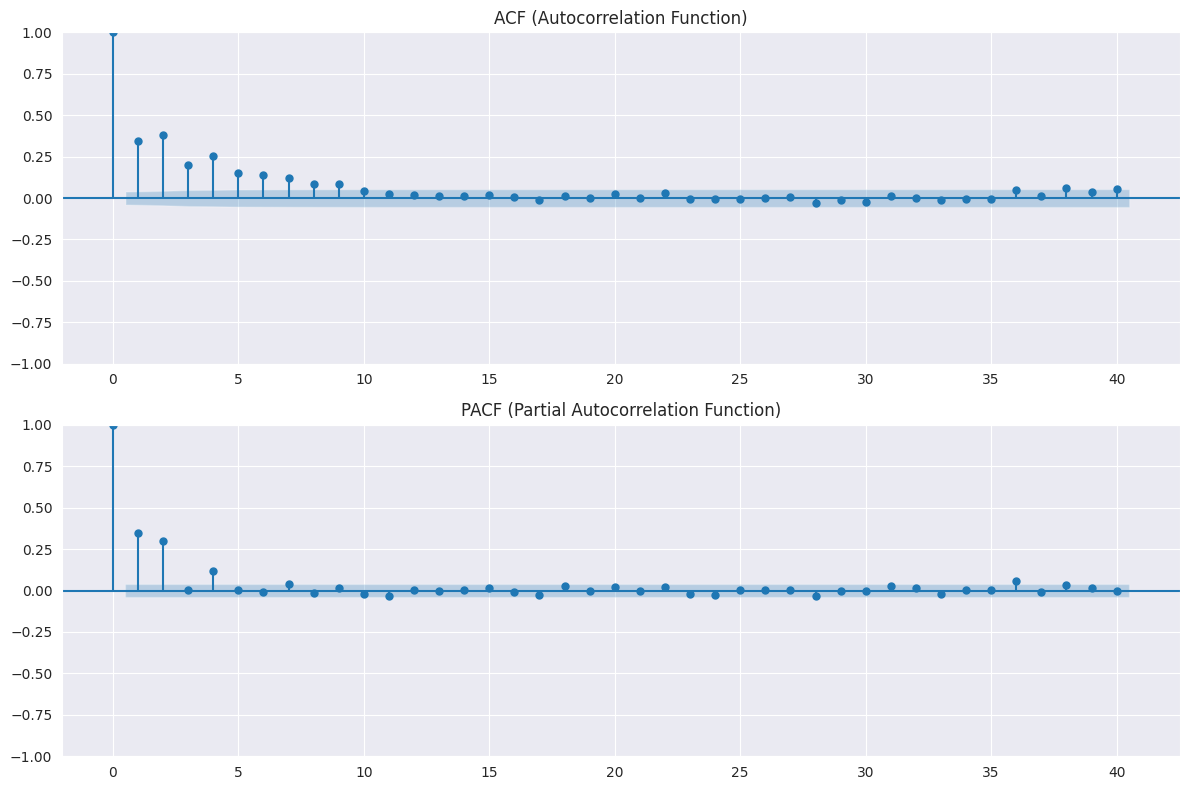

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_acf(daily_ts_data, lags=40, alpha=0.05, ax=ax1)  
ax1.set_title('ACF (Autocorrelation Function)')

# Plot PACF (Partial Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_pacf(daily_ts_data, lags=40, alpha=0.05, ax=ax2)  
ax2.set_title('PACF (Partial Autocorrelation Function)')

plt.tight_layout();

# LSTM

The Long Short Term Memory (LSTM) is the advanced type of RNN, which was designed to prevent both decaying and exploding gradient problems. Just like RNN, LSTM has repeating modules, but the structure is different. Instead of having a single layer of tanh, LSTM has four interacting layers that communicate with each other. This four-layered structure helps LSTM retain long-term memory and can be used in several sequential problems including machine translation, speech synthesis, speech recognition, and handwriting recognition.

In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

from scipy import stats
import tensorflow as tf
from tensorflow.random import set_seed
from tsaug import TimeWarp, Drift, AddNoise
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import MinMaxScaler, RobustScaler


SEED = 29
set_seed(SEED)
np.random.seed(SEED)

In [23]:
series_to_df = daily_ts_data.to_frame()
series_to_df.head()

,Total_Disasters
Timestamp,
1953-05-02,1.0
1953-05-15,1.0
1953-05-29,1.0
1953-06-02,1.0
1953-06-06,1.0


Skewness: 8.49
Kurtosis: 116.59


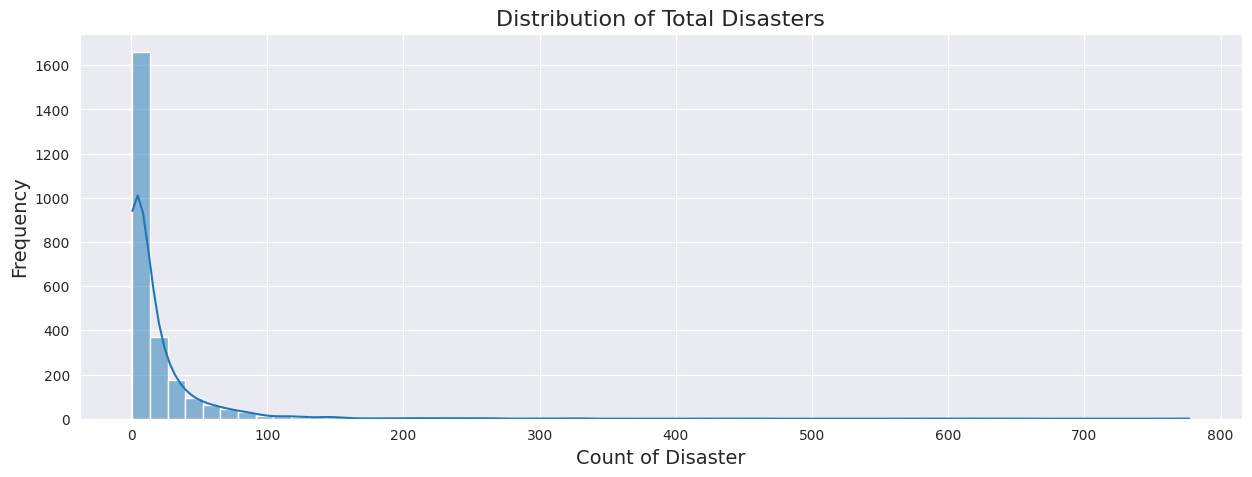

In [24]:
skewness = series_to_df['Total_Disasters'].skew()
kurtosis_value = series_to_df['Total_Disasters'].kurt()

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis_value:.2f}")

plt.figure(figsize=(15, 5))
sns.histplot(series_to_df['Total_Disasters'], kde=True, bins=60)

plt.title('Distribution of Total Disasters', fontsize=16)
plt.xlabel('Count of Disaster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.grid(True);

- The skewness of `count_of_disaster` is **8.49**, and the kurtosis is **116.59**, indicating that the distribution is **heavily right-skewed.**
- Additionally, the variable is **not normally distributed**, so we will use either `MinMaxScaler` or `RobustScaler` (probably).

## Data Preparation

In [25]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, batch_size=32):
        """
        Initialize the WindowGenerator for univariate time series data.

        Args:
            input_width (int): The number of input time steps.
            label_width (int): The number of label time steps.
            shift (int): The time step shift between input and label.
            train_df (np.ndarray): Training data (scaled).
            val_df (np.ndarray): Validation data (scaled).
            test_df (np.ndarray): Test data (scaled).
            batch_size (int): Batch size for the dataset.
        """
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.label_start = self.total_window_size - label_width
        self.labels_slice = slice(self.label_start, None)

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

    def split_window(self, window):
        """
        Splits a window of data into inputs and labels.

        Args:
            window (np.ndarray): A window of data.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Inputs and labels.
        """
        inputs = window[:, self.input_slice, :]
        labels = window[:, self.labels_slice, :]
        return inputs, labels

    def make_dataset(self, data, augment=False, augmenter=None, scaler=None, n_samples=None):
        """
        Creates a tf.data.Dataset from the input data and returns X and y.

        Args:
            data (np.ndarray): Input data for the dataset.
            augment (bool): Whether to apply augmentation.
            augmenter: Augmentation pipeline.
            scaler: Scaler for normalizing augmented data.
            n_samples (int): Desired number of augmented samples.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Inputs and labels arrays.
        """
        data = np.array(data, dtype=np.float32)  
        dataset = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size,
        )

        # Collect all windows
        X, y = [], []
        for window in dataset:
            inputs, labels = self.split_window(window)
            X.append(inputs.numpy())
            y.append(labels.numpy())

        X = np.concatenate(X, axis=0)
        y = np.concatenate(y, axis=0)

        print(f"Shape of X (original): {X.shape}")
        print(f"Shape of y (original): {y.shape}")
        
        # Handle augmentation if required
        if augment and augmenter is not None and n_samples is not None:
            X_aug, y_aug = self.augment_data(X, y, augmenter, scaler, n_samples)
            
            print(f"Shape of X (augmented): {X_aug.shape}")
            print(f"Shape of y (augmented): {y_aug.shape}")
            
            # Combine original data with augmented data
            X = np.concatenate([X, X_aug], axis=0)
            y = np.concatenate([y, y_aug], axis=0)
            
            print(f"Shape of X (original + augmented): {X.shape}")
            print(f"Shape of y (original + augmented): {y.shape}")

        return X, y

    def augment_data(self, X, y, augmenter, scaler, n_samples):
        """
        Augments the dataset to generate the desired number of samples.

        Args:
            X (np.ndarray): Input features.
            y (np.ndarray): Labels.
            augmenter: Augmentation pipeline.
            scaler: Scaler to normalize augmented data.
            n_samples (int): Number of desired augmented samples.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Augmented features and labels.
        """
        X_aug, y_aug = [], []

        while len(X_aug) < n_samples:
            for i in range(X.shape[0]):
                x_aug_instance, y_aug_instance = augmenter.augment(X[i].flatten(), y[i].flatten())
                x_aug_instance = scaler.transform(x_aug_instance.reshape(-1, 1)).flatten()
                y_aug_instance = scaler.transform(y_aug_instance.reshape(-1, 1)).flatten()

                X_aug.append(x_aug_instance.reshape(-1, 1))
                y_aug.append(y_aug_instance.reshape(-1, 1))

                if len(X_aug) >= n_samples:
                    break
        
        if np.isnan(np.array(X_aug)).any() or np.isnan(np.array(y_aug)).any():
            raise ValueError("NaN values detected in augmented data.")

        return np.array(X_aug), np.array(y_aug)
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)


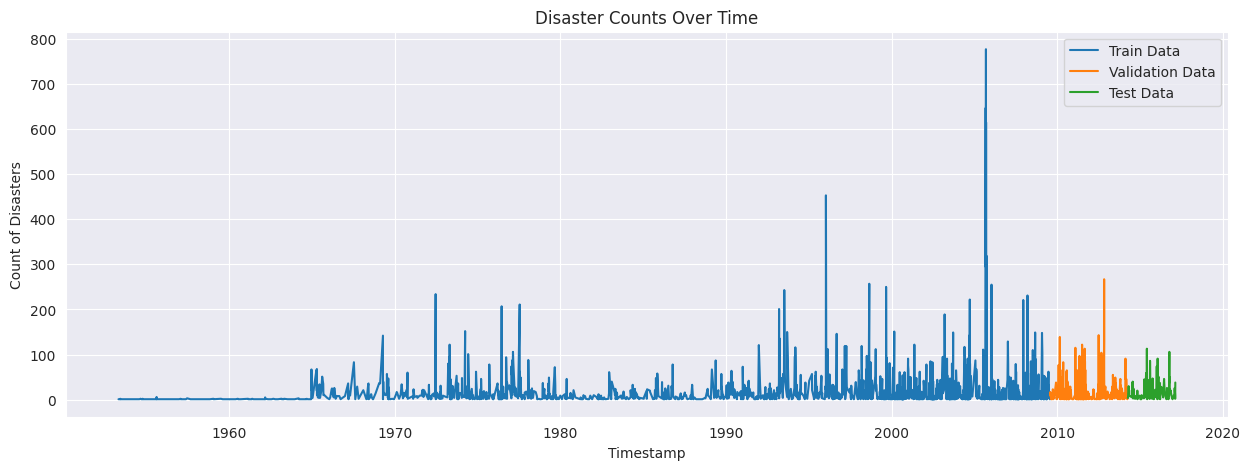

In [26]:
""" Data Preparation """

# valid_start_date = '2012-01-01'
# test_start_date = '2015-02-01'

# train_df = series_to_df.loc[series_to_df.index < valid_start_date, ['Total_Disasters']]
# val_df = series_to_df.loc[
#     (series_to_df.index >= valid_start_date) & (series_to_df.index < test_start_date), 
#     ['Total_Disasters']
# ]
# test_df = series_to_df.loc[series_to_df.index >= test_start_date, ['Total_Disasters']]


n = len(series_to_df)
train_df = series_to_df[0:int(n * 0.8)]
val_df = series_to_df[int(n * 0.8):int(n * 0.95)]
test_df = series_to_df[int(n * 0.95):]

# Plotting the training, validation, and test data
plt.figure(figsize=(15, 5))
plt.plot(train_df.index, train_df['Total_Disasters'], label='Train Data')
plt.plot(val_df.index, val_df['Total_Disasters'], label='Validation Data')
plt.plot(test_df.index, test_df['Total_Disasters'], label='Test Data')

plt.xlabel('Timestamp')
plt.ylabel('Count of Disasters')
plt.title('Disaster Counts Over Time')
plt.legend();

In [101]:
print(f"Training:   {train_df.index.min()} to {train_df.index.max()}")
print(f"Validation: {val_df.index.min()} to {val_df.index.max()}")
print(f"Test:       {test_df.index.min()} to {test_df.index.max()}")

Training:   1953-05-02 00:00:00 to 2011-12-22 00:00:00
Validation: 2012-01-06 00:00:00 to 2015-01-27 00:00:00
Test:       2015-02-03 00:00:00 to 2017-02-14 00:00:00


In [102]:
# Transform the data
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = RobustScaler()

train_df_scaled = scaler.fit_transform(train_df[['Total_Disasters']].values)
val_df_scaled = scaler.transform(val_df[['Total_Disasters']].values)
test_df_scaled = scaler.transform(test_df[['Total_Disasters']].values)


# Initialize the WindowGenerator
window_generator = WindowGenerator(input_width=12,  # 12 months of input 
                                   label_width=12,  # 10 month of output
                                   shift=1,         # Predict the next month   
                                   train_df=train_df_scaled, 
                                   val_df=val_df_scaled, 
                                   test_df=test_df_scaled,
                                   batch_size=32)


# Get the training data as X (inputs) and y (labels)
X_train, y_train = window_generator.make_dataset(data=window_generator.train_df,
                                                 augment=True,
                                                 augmenter=None,
                                                 scaler=None,
                                                 n_samples=None)

# Get the validation data
X_val, y_val = window_generator.make_dataset(data=window_generator.val_df,
                                             augment=True,
                                             augmenter=None,
                                             scaler=None,
                                             n_samples=None)

# Get the test data
X_test, y_test = window_generator.make_dataset(data=window_generator.test_df,
                                               augment=True,
                                               augmenter=None,
                                               scaler=None,
                                               n_samples=None)



Shape of X (original): (1993, 12, 1)
Shape of y (original): (1993, 12, 1)
Shape of X (original): (364, 12, 1)
Shape of y (original): (364, 12, 1)
Shape of X (original): (114, 12, 1)
Shape of y (original): (114, 12, 1)


In [103]:
print(np.isnan(X_train).any())
print(np.isnan(X_val).any())
print(np.isnan(X_test).any())
print(np.isnan(y_train).any())
print(np.isnan(y_val).any())
print(np.isnan(y_test).any())

False
False
False
False
False
False


In [104]:
print("Minimum value of y_train : ", np.min(y_train))
print("Maximum value of y_train : ", np.max(y_train))  
print("Average absolute value of y_train : ", np.mean(np.abs(y_train)))  
print("Count values close to zero : ", np.sum(np.abs(y_train) < 1e-5))
print()
print("Minimum value of y_val : ", np.min(y_val))
print("Maximum value of y_val : ", np.max(y_val))  
print("Average absolute value of y_val : ", np.mean(np.abs(y_val)))  
print("Count values close to zero : ", np.sum(np.abs(y_val) < 1e-5))
print()
print("Minimum value of y_test : ", np.min(y_test))
print("Maximum value of y_test : ", np.max(y_test))  
print("Average absolute value of y_test : ", np.mean(np.abs(y_test)))  
print("Count values close to zero : ", np.sum(np.abs(y_test) < 1e-5))

Minimum value of y_train :  -0.2777778
Maximum value of y_train :  42.833332
Average absolute value of y_train :  0.9084109
Count values close to zero :  804

Minimum value of y_val :  -0.2777778
Maximum value of y_val :  14.5
Average absolute value of y_val :  0.8443223
Count values close to zero :  185

Minimum value of y_test :  -0.2777778
Maximum value of y_test :  5.9444447
Average absolute value of y_test :  0.93010885
Count values close to zero :  59


In [59]:
# """ 
#     Data Augmentation
# """



# # Our augmenter
# augmenter = (
#     TimeWarp(n_speed_change=1, prob=0.33, seed=SEED)  # Ensure this does not violate sequence order
#     + Drift(max_drift=(0.1, 0.5), seed=SEED)          # Small drift values to avoid large displacements
#     + AddNoise(scale=0.1, prob=0.3, seed=SEED)        # Adding some noise for robustness
# )



# # Generate augmented dataset with 10,000 samples
# X_train_aug, y_train_aug = window_generator.make_dataset(data=window_generator.train_df,
#                                                          augment=True,
#                                                          augmenter=augmenter,
#                                                          scaler=scaler,
#                                                          n_samples=1000)


In [94]:
# print(np.isnan(X_train_aug).any())
# print("Minimum value of the  y_train (original + augmented): ", np.min(y_train_aug))
# print("Maximum value of the  y_train (original + augmented): ", np.max(y_train_aug))  
# print("Average absolute value of the  y_train (original + augmented): ", np.mean(np.abs(y_train_aug)))  
# print("Count values close to zero (original + augmented): ", np.sum(np.abs(y_train_aug) < 1e-5))

In [30]:
# Apply Log Transformation to takcle Heteroscedasticity

y_train_log = np.log1p(y_train)
# y_train_aug_log = np.log1p(y_train_aug)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

There's one additional [rule of thumb](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) that helps for supervised learning problems. 

We can usually prevent over-fitting if we keep our number of neurons below:

1. Rule of thumb 1:

$$ N_h = \frac{N_s}{\alpha \cdot (N_i + N_o)} $$

Where:
- $N_i$ = number of input neurons.
- $N_o$ = number of output neurons.
- $N_s$ = number of samples in the training data set.
- $\alpha$ = an arbitrary scaling factor, usually between 2 and 10.

2. Rule of thumb 2:

The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.

In [69]:
def rule_of_thumb_1(train_data, alpha=5) -> int:
    if alpha < 2 or alpha > 10:
        raise ValueError("Alpha must be between 2 and 10.")
    
    # Number of samples (N_s), number of input neurons (N_i), number of input features (N_f)
    N_s, N_i, N_f = train_data.shape 
    N_o = 1  # For univariate time series
    
    # Calculate N_h 
    N_h = int(N_s / (alpha * (N_i + N_o)))
    
    return N_h

def rule_of_thumb_2(train_data) -> int:
    n_samples, time_steps, n_features = train_data.shape
    input_layer_size = time_steps * n_features  
    output_layer_size = 1    # For univariate time series
    
    hidden_neurons = int((2 / 3) * input_layer_size + output_layer_size)
    
    return hidden_neurons



# Calculate the number of hidden units: N_h 
ALPHA = 10
TRAIN_DATA = X_train
hidden_neurons = rule_of_thumb_1(TRAIN_DATA, alpha=ALPHA)
# hidden_neurons = rule_of_thumb_2(TRAIN_DATA)
print(f"Suggested number of hidden units (N_h): {hidden_neurons}")


Suggested number of hidden units (N_h): 15


In [70]:
def plot_loss_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();  

 
def plot_forecast(y_original, predictions, title):
    time_steps = np.arange(1, len(predictions) + 1)
    plt.figure(figsize=(15, 5))
    plt.plot(time_steps, y_original, label='Actual', color='orange')
    plt.plot(time_steps, predictions, label='Forecast', color='green')
    plt.title(f"{title} - Forecast vs. Actual Values ")
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend();
    

def perform_wilcoxon_test_and_correlation(y_original, predictions):
    # Calculate the Kendall correlation coefficient (non-normal distribution)
    kendall_corr, kendall_p_value = stats.kendalltau(predictions.flatten(), y_original.flatten())

    # Perform Wilcoxon signed-rank test to compare the actual and predicted values (non-normal distribution)
    wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(predictions.flatten(), y_original.flatten())

    print(f"\nKendall correlation coefficient (Tau): {kendall_corr}")
    print(f"P-value for Kendall correlation: {kendall_p_value}")
    print(f"Wilcoxon statistic: {wilcoxon_stat}")
    print(f"P-value from Wilcoxon signed-rank test: {wilcoxon_p_value}\n")

    print("Conclusion for Kendall's Tau:")
    if kendall_p_value < 0.05:
        print("The Kendall correlation between the prediction and the actual is statistically significant.")
    else:
        print("The Kendall correlation between the prediction and the actual is not statistically significant.")

    print("\nConclusion for Wilcoxon signed-rank test:")
    if wilcoxon_p_value < 0.05:
        print("There is a statistically significant difference between the average predicted and actual values.")
    else:
        print("There is no statistically significant difference between the average predicted and actual values.")
    
    
def plot_zoomed_forecast(actual_values, predictions, start_index, end_index, title):
    predictions_zoom = predictions[start_index:end_index]
    actual_zoom = actual_values[start_index:end_index]
    time_steps_zoom = np.arange(start_index, end_index)

    plt.figure(figsize=(15, 5))
    plt.plot(time_steps_zoom, actual_zoom, label='Actual', color='orange')
    plt.plot(time_steps_zoom, predictions_zoom, label='Forecast', color='green')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f"{title} - Forecast vs. Actual Values : Time Steps {start_index} to {end_index} ")
    plt.legend();


def plot_residual_variance_across_prediction(prediction, residuals, title):
    prediction_1d = prediction.flatten()
    bins = np.linspace(np.min(prediction_1d), np.max(prediction_1d), num=40)
    bin_indices = np.digitize(prediction_1d, bins)
    # Compute residual variances for non-empty bins
    residual_variances = []
    for i in range(1, len(bins)):
        bin_residuals = residuals[bin_indices == i]
        if len(bin_residuals) > 0:  # Skip empty bins
            residual_variances.append(np.var(bin_residuals))
        else:
            residual_variances.append(np.nan)  # Mark empty bins
    # Filter out NaN values to avoid plotting issues
    bins_filtered = bins[:-1][~np.isnan(residual_variances)]
    residual_variances_filtered = np.array(residual_variances)[~np.isnan(residual_variances)]
    plt.figure(figsize=(15, 5))
    plt.plot(bins_filtered, residual_variances_filtered, marker='o')
    plt.xlabel('Predicted Value Bins')
    plt.ylabel('Residual Variance')
    plt.title(f'{title} - Residual Variance Across Predicted Value Bins');
    
    
def plot_residuals(residuals, title):
    plt.figure(figsize=(15, 5))
    plt.hist(residuals, bins=50, edgecolor='k')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Distribution of Residuals');
    

def perform_breusch_pagan_test(predictions, residuals):
    X_val_with_const = sm.add_constant(predictions)
    bp_test = het_breuschpagan(residuals, X_val_with_const)
    bp_test_results = dict(zip(['Lagrange Multiplier Statistic', 'p-value', 'F-value', 'F p-value'], bp_test))
    bp_test_stat = bp_test_results["Lagrange Multiplier Statistic"]
    bp_p_value = bp_test_results["p-value"]    

    print("Breusch-Pagan Test Results:")
    print(f"Lagrange Multiplier Statistic: {bp_test_stat}")
    print(f"P-value: {bp_p_value}\n")
    if bp_p_value < 0.05:
        print("Heteroscedasticity detected! The variance of the residual, or error term, in the regression model is not constant.")
    else:
        print("Homoscedasticity detected! The variance of the residual, or error term, in the regression model is constant.")
         

In [71]:
################  Define custom metrics  ################

# Define a small epsilon value to avoid division by zero
epsilon = tf.keras.backend.epsilon()

def mape(y_true, y_pred):
    y_true = tf.where(y_true == 0, epsilon, y_true)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

def me(y_true, y_pred):
    return tf.reduce_mean(y_true - y_pred)

def mpe(y_true, y_pred):
    y_true = tf.where(y_true == 0, epsilon, y_true)
    return tf.reduce_mean((y_true - y_pred) / y_true) * 100

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r2(y_true, y_pred):
    sum_squares_residuals = tf.reduce_sum(tf.square(y_true - y_pred))
    sum_squares_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1.0 - tf.divide(sum_squares_residuals, sum_squares_total)


def weighted_huber_loss(y_true, y_pred):
    residuals = tf.abs(y_true - y_pred)
    weights = 1 / (1 + residuals)  
    huber_loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    return tf.reduce_mean(weights * huber_loss)

def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

#### LSTM Model

In [105]:
# Define the hyperparameters
HIDDEN_UNITS = hidden_neurons 
MAX_EPOCHS = 2000
PATIENCE = 5
# BATCH_SIZE = 32

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

# Build the LSTM model
lstm_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),  # m timesteps, n feature per timestep
    tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    # tf.keras.layers.Dropout(0.1), 
    # tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    # tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(units=1)
])

lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 12, 15)         │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12, 1)          │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,036 (4.05 KB)

 Trainable params: 1,036 (4.05 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0)
    
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), #Adam(learning_rate=0.0001) or RMSprop(learning_rate=0.01)
                  loss=huber_loss, #weighted_huber_loss, huber_loss,
                  metrics=[r2, me, 'mse', 'mae', rmse, mape, mpe])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  restore_best_weights=True,
                                                  mode='min')

 
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.3, 
                                                    patience=5, 
                                                    min_lr=1e-6)
    

    # Fit the model with additional callbacks
history_lstm = history = lstm_model.fit(X_train, y_train,
                                        # batch_size=BATCH_SIZE,
                                        epochs=MAX_EPOCHS,
                                        validation_data=(X_val, y_val),
                                        callbacks=[early_stopping, lr_scheduler],
                                        verbose=1)


# Evaluate LSTM Model
lstm_train_performance = {}
lstm_val_performance = {}

lstm_train_performance['LSTM'] = lstm_model.evaluate(X_train, y_train, return_dict=True)
lstm_val_performance['LSTM'] = lstm_model.evaluate(X_val, y_val, verbose=1, return_dict=True)

Epoch 1/2000


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6144 - mae: 0.9305 - mape: 9147949.0000 - me: 0.4571 - mpe: -9122139.0000 - mse: 6.0647 - r2: 0.0166 - rmse: 2.2695 - val_loss: 0.5234 - val_mae: 0.8490 - val_mape: 16023172.0000 - val_me: 0.3269 - val_mpe: -16022881.0000 - val_mse: 2.3620 - val_r2: -0.0166 - val_rmse: 1.4951 - learning_rate: 0.0100
Epoch 2/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6065 - mae: 0.9234 - mape: 10341858.0000 - me: 0.4204 - mpe: -10257263.0000 - mse: 5.6970 - r2: 0.0495 - rmse: 2.2149 - val_loss: 0.5268 - val_mae: 0.8544 - val_mape: 16473263.0000 - val_me: 0.3219 - val_mpe: -16471643.0000 - val_mse: 2.3741 - val_r2: -0.0218 - val_rmse: 1.4990 - learning_rate: 0.0100
Epoch 3/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6034 - mae: 0.9195 - mape: 10564652.0000 - me: 0.4127 - mpe: -10437985.0000 - mse: 5.5470 - r2: 0.0627 - rmse: 2.1921 - val_loss: 0.5300 - val_mae: 0.8587 - val_mape: 17105768.0000 - val_me: 0.3160 - val_mpe: -17099932.000

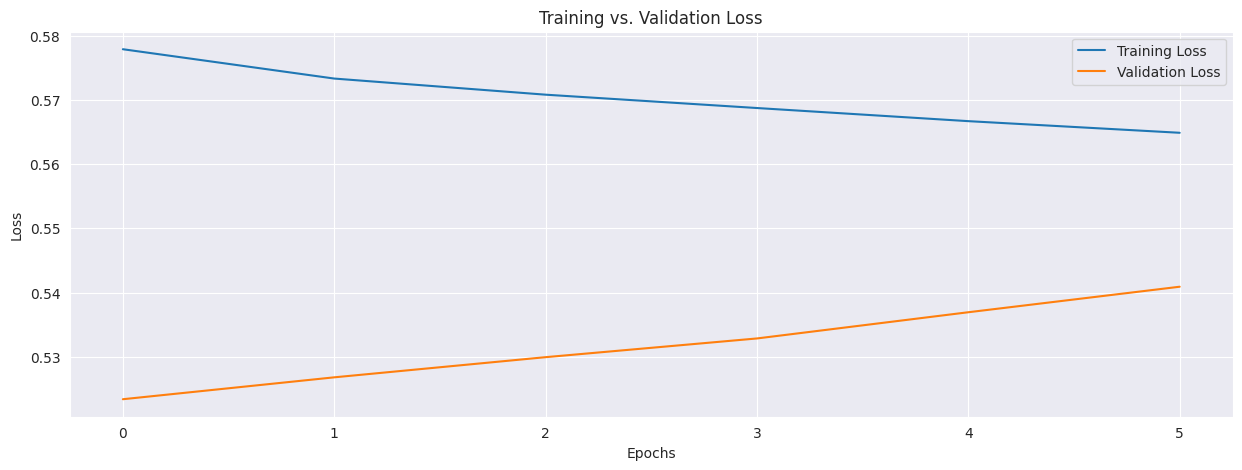

In [107]:
plot_loss_curves(history_lstm)

In [108]:
print("Performance on the training set")
pd.DataFrame(lstm_train_performance).T

Performance on the training set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,0.573981,0.886725,10705205.0,0.384406,-10559948.0,5.050976,0.045386,2.087988


In [109]:
print("Performance on the validation set")
pd.DataFrame(lstm_val_performance).T

Performance on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,0.523412,0.848974,16023172.0,0.326924,-16022881.0,2.362,-0.016596,1.495139


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Kendall correlation coefficient (Tau): 0.13342088697444682
P-value for Kendall correlation: 6.201554400282184e-38
Wilcoxon statistic: 4752022.0
P-value from Wilcoxon signed-rank test: 0.8203728908720922

Conclusion for Kendall's Tau:
The Kendall correlation between the prediction and the actual is statistically significant.

Conclusion for Wilcoxon signed-rank test:
There is no statistically significant difference between the average predicted and actual values.


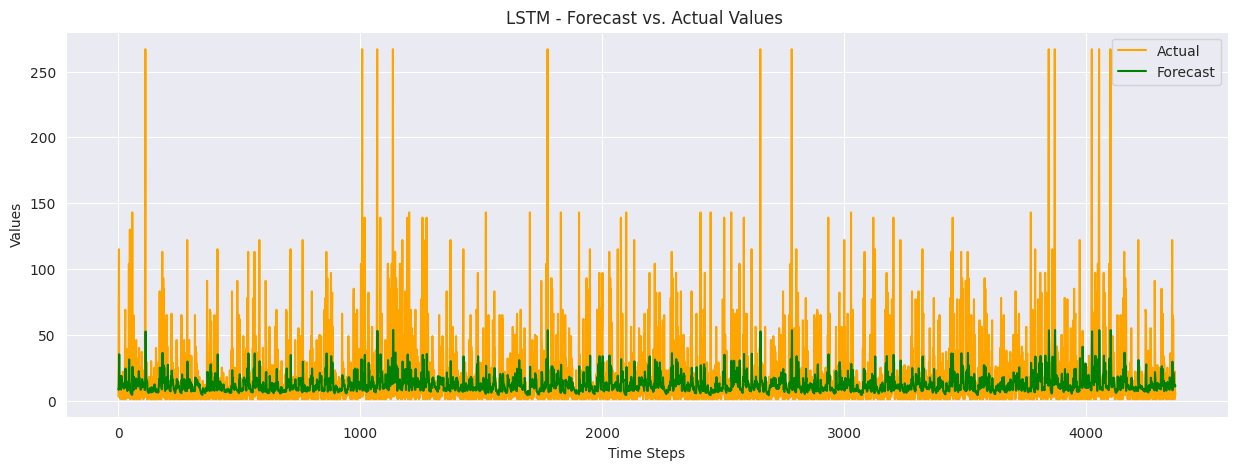

In [110]:
# Make predictions on the validation dataset
predictions_lstm = lstm_model.predict(X_val)  

""" Forecasting accuracy across all time steps """ 

# Reshape the true labels and the prediction
# y_val_reshape = y_val_log.reshape(-1, 1) 
y_val_reshape = y_val.reshape(-1, 1) 
predictions_lstm_reshape = predictions_lstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_lstm_original = scaler.inverse_transform(predictions_lstm_reshape)
y_val_original = scaler.inverse_transform(y_val_reshape)

# Directly apply inverse log transformation
# y_val_original = np.expm1(y_val_scaled)

# Perform Wilcoxon signed-rank test and Kendall correlation coefficient (non-normal distribution)
perform_wilcoxon_test_and_correlation(y_val_original, predictions_lstm_original)
    
# Plot the predictions against the true labels
plot_forecast(y_val_original, predictions_lstm_original, "LSTM")

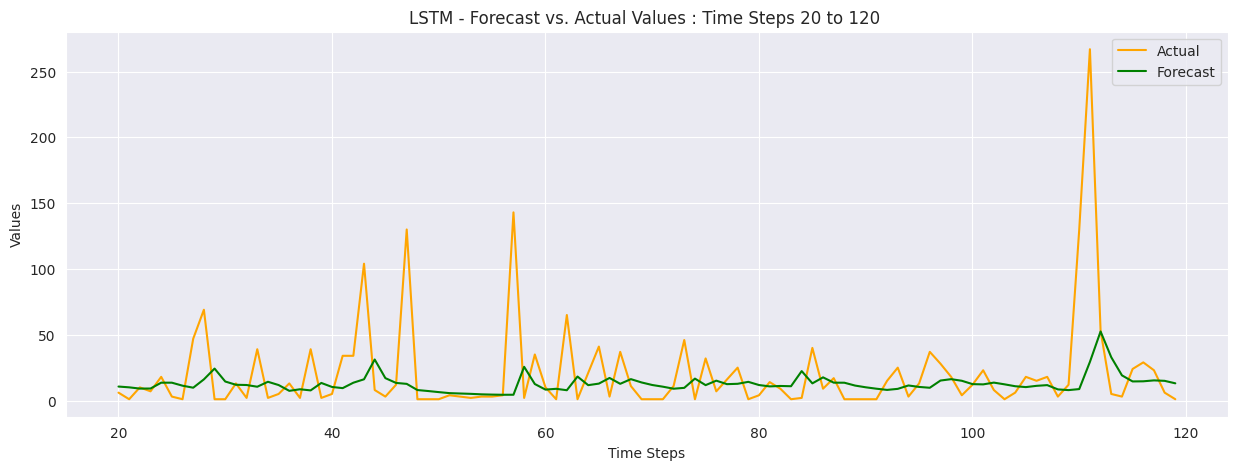

In [111]:
plot_zoomed_forecast(y_val_original, predictions_lstm_original, 20, 120, "LSTM")

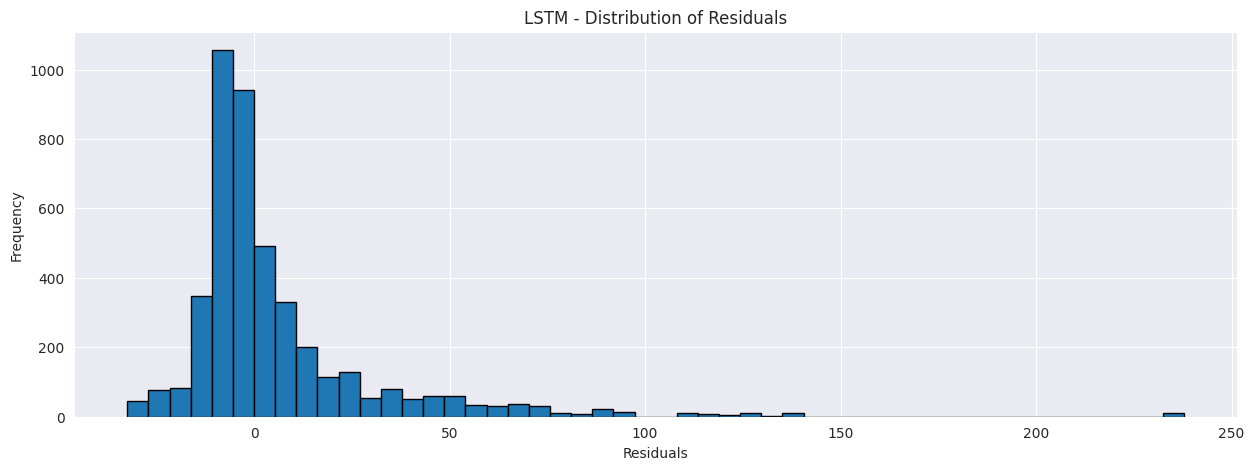

In [112]:
# Analyze residual
residuals_lstm = y_val_original - predictions_lstm_original

plot_residuals(residuals_lstm, "LSTM")

In [113]:
perform_breusch_pagan_test(predictions_lstm_original, residuals_lstm)

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 134.64210185162156
P-value: 3.953856887471944e-31

Heteroscedasticity detected! The variance of the residual, or error term, in the regression model is not constant.


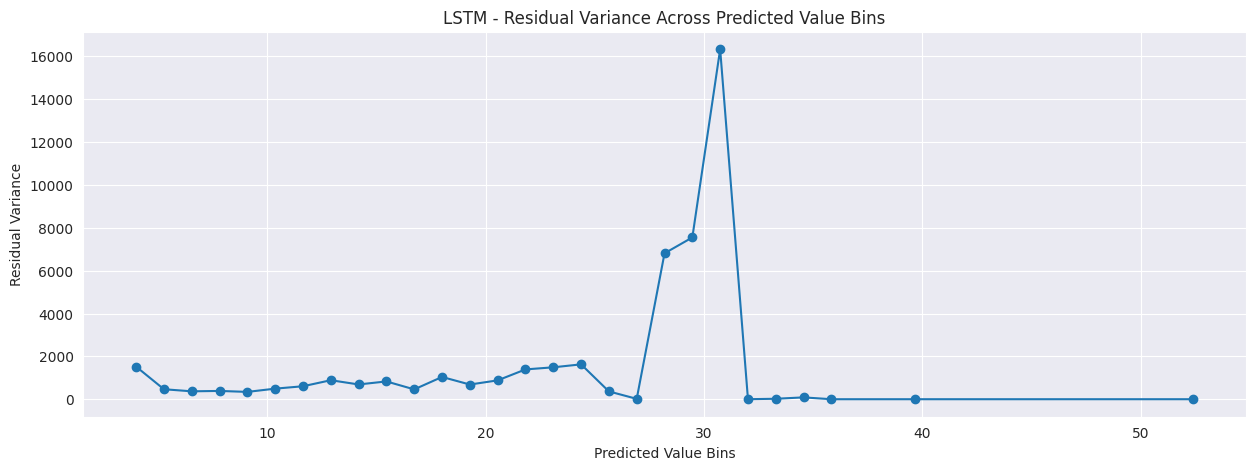

In [114]:
plot_residual_variance_across_prediction(predictions_lstm_original, residuals_lstm, "LSTM")

# Bi-LSTM

In [115]:
# Define the hyperparameters
HIDDEN_UNITS = hidden_neurons 
MAX_EPOCHS = 2000
PATIENCE = 10
# BATCH_SIZE = 32

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])


# Build the Bi-LSTM model
bi_lstm_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),  # m timesteps, n feature per timestep
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True)),
    tf.keras.layers.Dense(units=1)
])

bi_lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 12, 30)         │         2,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12, 1)          │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,071 (8.09 KB)

 Trainable params: 2,071 (8.09 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
# opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0)
    
bi_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), #Adam(learning_rate=0.0001)# RMSprop(learning_rate=0.01)
                      loss=huber_loss, #weighted_huber_loss, huber_loss,
                      metrics=[r2, me, 'mse', 'mae', rmse, mape, mpe])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  restore_best_weights=True,
                                                  mode='min')

 
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.3, 
                                                    patience=5, 
                                                    min_lr=1e-6)  

# Train Bi-LSTM Model
history_bi_lstm = bi_lstm_model.fit(X_train, y_train,
                                    # batch_size=BATCH_SIZE,
                                    epochs=MAX_EPOCHS,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stopping, lr_scheduler],
                                    verbose=1)


# Evaluate Bi-LSTM Model
bilstm_train_performance ={}
bilstm_val_performance = {}

bilstm_train_performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_train, y_train, return_dict=True)
bilstm_val_performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_val, y_val, verbose=1, return_dict=True)

Epoch 1/2000


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.5827 - mae: 0.8827 - mape: 9272203.0000 - me: 0.4594 - mpe: -9132244.0000 - mse: 6.0474 - r2: 0.0553 - rmse: 2.2454 - val_loss: 0.4514 - val_mae: 0.7643 - val_mape: 16983964.0000 - val_me: 0.2327 - val_mpe: -16099763.0000 - val_mse: 1.9231 - val_r2: 0.1834 - val_rmse: 1.3438 - learning_rate: 0.0010
Epoch 2/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5338 - mae: 0.8215 - mape: 11395724.0000 - me: 0.3638 - mpe: -10644313.0000 - mse: 5.4336 - r2: 0.1728 - rmse: 2.1140 - val_loss: 0.3990 - val_mae: 0.6976 - val_mape: 17304482.0000 - val_me: 0.1778 - val_mpe: -15980815.0000 - val_mse: 1.6186 - val_r2: 0.3192 - val_rmse: 1.2291 - learning_rate: 0.0010
Epoch 3/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4761 - mae: 0.7495 - mape: 10941989.0000 - me: 0.3075 - mpe: -9949677.0000 - mse: 4.9360 - r2: 0.2783 - rmse: 1.9928 - val_loss: 0.3163 - val_mae: 0.5921 - val_mape: 14936228.0000 - val_me: 0.1353 - val_mpe: -13070139.0000 -

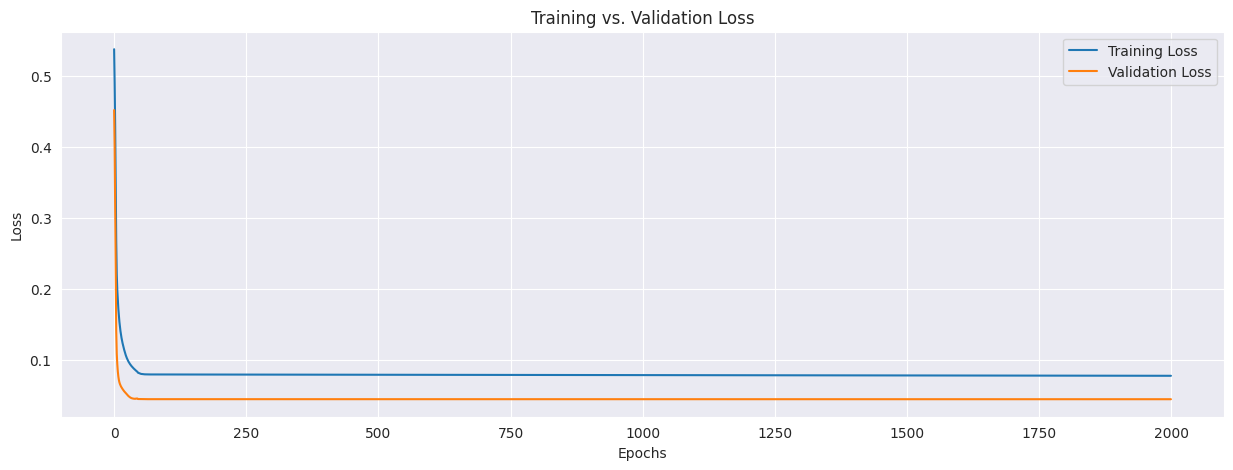

In [117]:
plot_loss_curves(history_bi_lstm)

In [118]:
print("Performance on the training set")
pd.DataFrame(bilstm_train_performance).T

Performance on the training set


,loss,mae,mape,me,mpe,mse,r2,rmse
Bi-LSTM,0.078001,0.135769,1722692.125,0.058994,-843300.5625,0.881838,0.882417,0.744058


In [119]:
print("Performance on the validation set")
pd.DataFrame(bilstm_val_performance).T

Performance on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
Bi-LSTM,0.045073,0.101369,2134849.5,0.027949,-1443267.875,0.20363,0.915281,0.417302


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

Kendall correlation coefficient (Tau): 0.876793302189418
P-value for Kendall correlation: 0.0
Wilcoxon statistic: 4441069.0
P-value from Wilcoxon signed-rank test: 7.566362106466191e-05

Conclusion for Kendall's Tau:
The Kendall correlation between the prediction and the actual is statistically significant.

Conclusion for Wilcoxon signed-rank test:
There is a statistically significant difference between the average predicted and actual values.


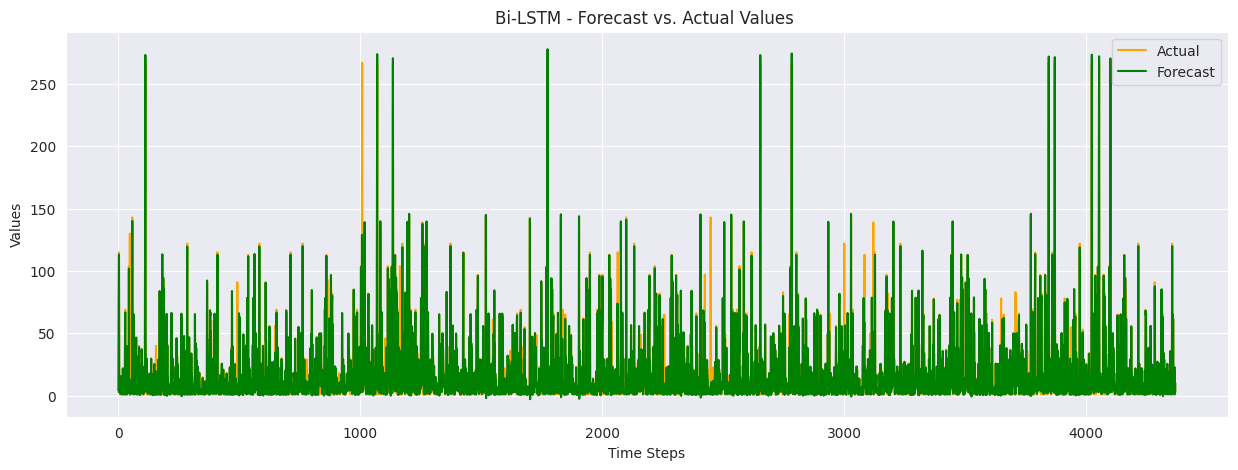

In [120]:
# Make predictions on the validation dataset
predictions_bilstm = bi_lstm_model.predict(X_val) 

""" Forecasting accuracy across all time steps """  

# Reshape the true labels and the prediction
y_val_reshape = y_val.reshape(-1, 1) 
predictions_bilstm_reshape = predictions_bilstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_bilstm_original = scaler.inverse_transform(predictions_bilstm_reshape)
y_val_original = scaler.inverse_transform(y_val_reshape)

# Perform Wilcoxon signed-rank test and Kendall correlation coefficient (non-normal distribution)
perform_wilcoxon_test_and_correlation(predictions_bilstm_original, y_val_original)

# Plot the predictions against the true labels
plot_forecast(y_val_original, predictions_bilstm_original, "Bi-LSTM")

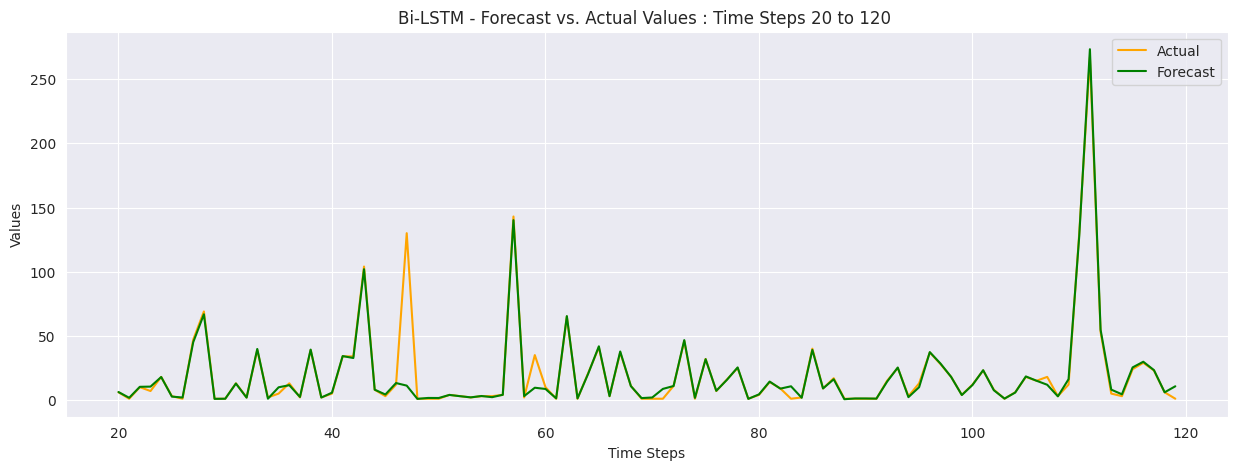

In [121]:
plot_zoomed_forecast(y_val_original, predictions_bilstm_original, 20, 120, "Bi-LSTM")

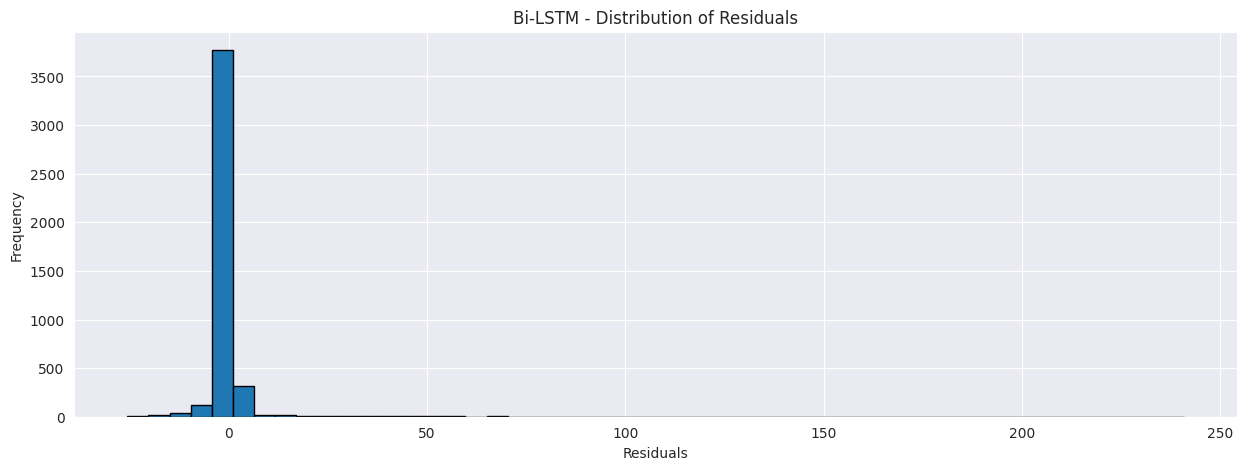

In [122]:
# Analyze residual
residuals_bilstm = y_val_original - predictions_bilstm_original

plot_residuals(residuals_bilstm, "Bi-LSTM")

In [123]:
perform_breusch_pagan_test(predictions_bilstm_original, residuals_bilstm)

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 0.0528242090811073
P-value: 0.8182198482011825

Homoscedasticity detected! The variance of the residual, or error term, in the regression model is constant.


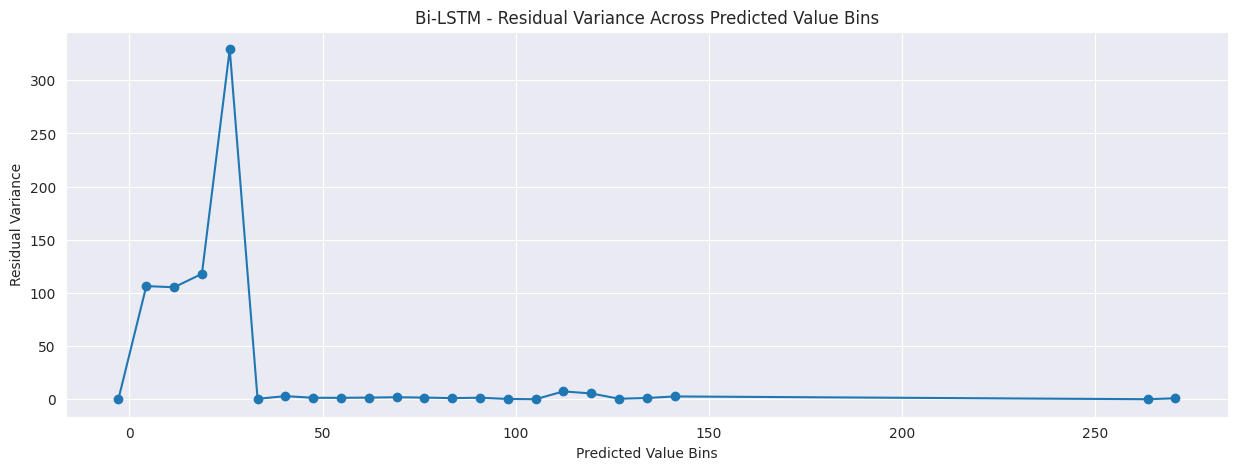

In [124]:
plot_residual_variance_across_prediction(predictions_bilstm_original, residuals_bilstm, "Bi-LSTM")

# GRU

The gated recurrent unit (GRU) is a variation of LSTM as both have design similarities, and in some cases, they produce similar results. GRU uses an update gate and reset gate to solve the vanishing gradient problem. These gates decide what information is important and pass it to the output. The gates can be trained to store information from long ago, without vanishing over time or removing irrelevant information.

Unlike LSTM, GRU does not have cell state $C_t$. It only has a hidden state $h_t$, and due to the simple architecture, GRU has a lower training time compared to LSTM models. The GRU architecture is easy to understand as it takes input $x_t$ and the hidden state from the previous timestamp $h_{t-1}$ and outputs the new hidden state $h_t$. 

In [125]:
# Define the hyperparameters
HIDDEN_UNITS = hidden_neurons 
MAX_EPOCHS = 2000
PATIENCE = 5
# BATCH_SIZE = 32

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])


# Build GRU model
gru_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),  # m timesteps, n feature per timestep
    tf.keras.layers.GRU(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

gru_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 12, 15)         │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 12, 15)         │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12, 1)          │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266 (8.85 KB)

 Trainable params: 2,266 (8.85 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
# opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0)
    
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #Adam(learning_rate=0.0001)# RMSprop(learning_rate=0.01)
                  loss=weighted_huber_loss, #weighted_huber_loss, huber_loss,
                  metrics=[r2, me, 'mse', 'mae', rmse, mape, mpe])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  restore_best_weights=True,
                                                  mode='min')

 
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.3, 
                                                    patience=5, 
                                                    min_lr=1e-6)  

# Train GRU Model
history_gru = gru_model.fit(X_train, y_train,
                            # batch_size=BATCH_SIZE,
                            epochs=MAX_EPOCHS,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, lr_scheduler],
                            verbose=1)


# Evaluate GRU Model
gru_train_performance = {}
gru_val_performance = {}

gru_train_performance['GRU'] = gru_model.evaluate(X_train, y_train, return_dict=True)
gru_val_performance['GRU'] = gru_model.evaluate(X_val, y_val, verbose=1, return_dict=True)


Epoch 1/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.4123 - mae: 0.9593 - mape: 11602234.0000 - me: 0.4065 - mpe: -11485789.0000 - mse: 6.1299 - r2: 0.0075 - rmse: 2.2810 - val_loss: 0.3265 - val_mae: 0.8799 - val_mape: 19599386.0000 - val_me: 0.2019 - val_mpe: -19599030.0000 - val_mse: 2.3193 - val_r2: 0.0101 - val_rmse: 1.4781 - learning_rate: 0.0010
Epoch 2/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3955 - mae: 1.0077 - mape: 16535618.0000 - me: 0.2414 - mpe: -16535237.0000 - mse: 5.9807 - r2: 0.0320 - rmse: 2.2528 - val_loss: 0.3267 - val_mae: 0.8832 - val_mape: 20181000.0000 - val_me: 0.1901 - val_mpe: -20180640.0000 - val_mse: 2.3105 - val_r2: 0.0131 - val_rmse: 1.4756 - learning_rate: 0.0010
Epoch 3/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3945 - mae: 1.0088 - mape: 16438138.0000 - me: 0.2352 - mpe: -16437755.0000 - mse: 5.9844 - r2: 0.0338 - rmse: 2.2521 - val_loss: 0.3265 - val_mae: 0.8854 - val_mape: 20531556.0000 - val_me: 0.1841 - val_mpe

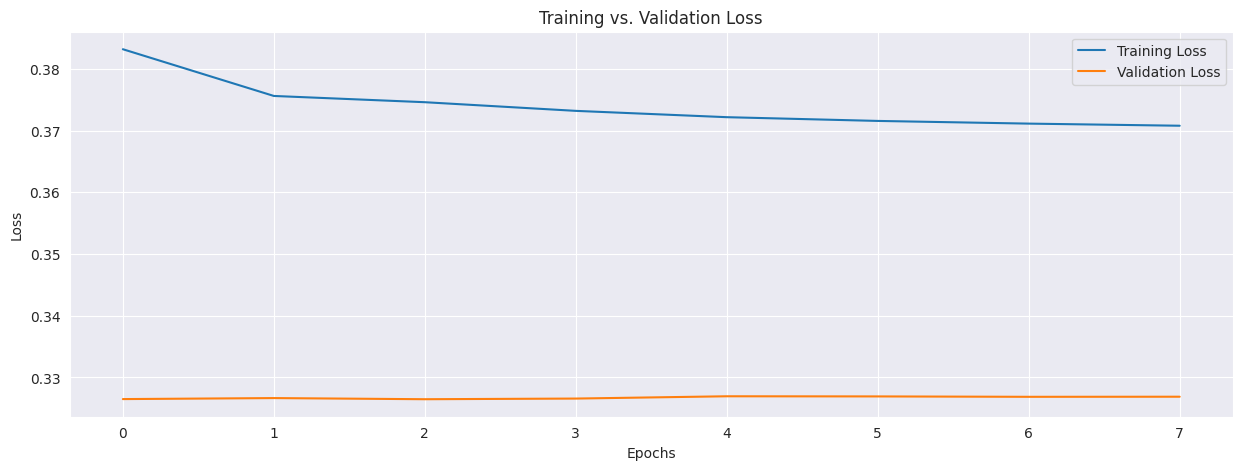

In [127]:
plot_loss_curves(history_gru)

In [128]:
print("Performance on the training set")
pd.DataFrame(gru_train_performance).T

Performance on the training set


,loss,mae,mape,me,mpe,mse,r2,rmse
GRU,0.372229,0.961894,15638420.0,0.22907,-15638052.0,5.202202,0.039567,2.105664


In [129]:
print("Performance on the validation set")
pd.DataFrame(gru_val_performance).T

Performance on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
GRU,0.326466,0.885367,20531556.0,0.184133,-20531192.0,2.30652,0.014223,1.474605


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Kendall correlation coefficient (Tau): 0.13397428702890304
P-value for Kendall correlation: 3.100934262521767e-38
Wilcoxon statistic: 3988309.0
P-value from Wilcoxon signed-rank test: 6.014807704068767e-21

Conclusion for Kendall's Tau:
The Kendall correlation between the prediction and the actual is statistically significant.

Conclusion for Wilcoxon signed-rank test:
There is a statistically significant difference between the average predicted and actual values.


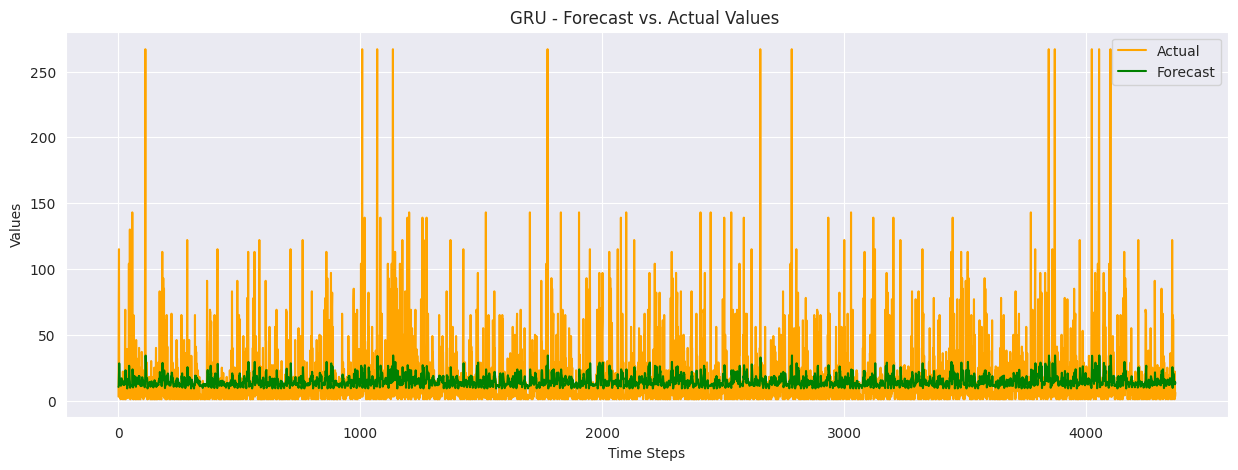

In [130]:
# Make predictions on the validation dataset
predictions_gru = gru_model.predict(X_val)  

""" Forecasting accuracy across all time steps """ 

# Reshape the true labels and the prediction
y_val_reshape = y_val.reshape(-1, 1) 
predictions_gru_reshape = predictions_gru.reshape(-1, 1)  

# Apply inverse transformation 
predictions_gru_original = scaler.inverse_transform(predictions_gru_reshape)
y_val_original = scaler.inverse_transform(y_val_reshape)

# Perform Wilcoxon signed-rank test and Kendall correlation coefficient (non-normal distribution)
perform_wilcoxon_test_and_correlation(predictions_gru_original, y_val_original)

# Plot the predictions against the true labels
plot_forecast(y_val_original, predictions_gru_original, "GRU")

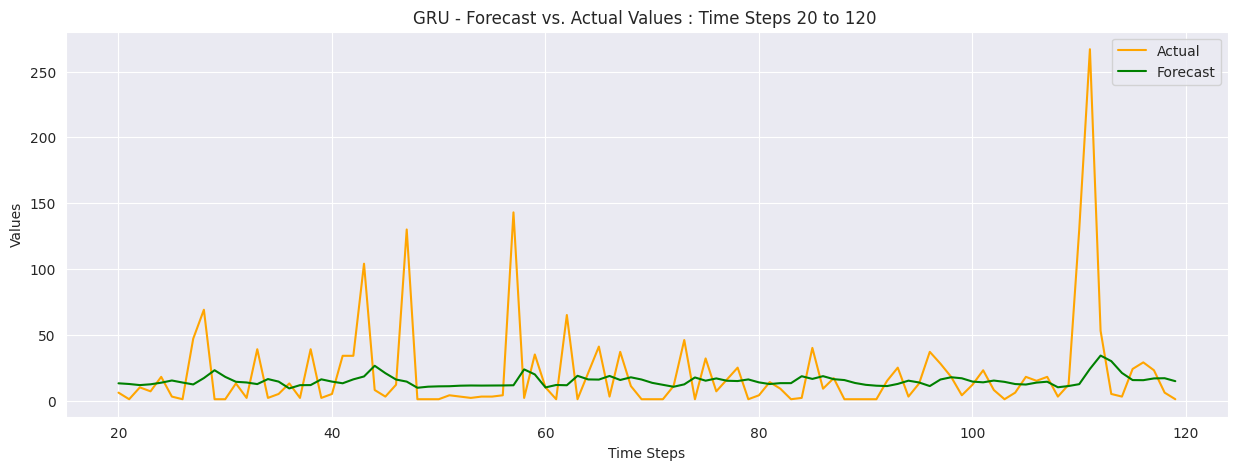

In [131]:
plot_zoomed_forecast(y_val_original, predictions_gru_original, 20, 120, "GRU")

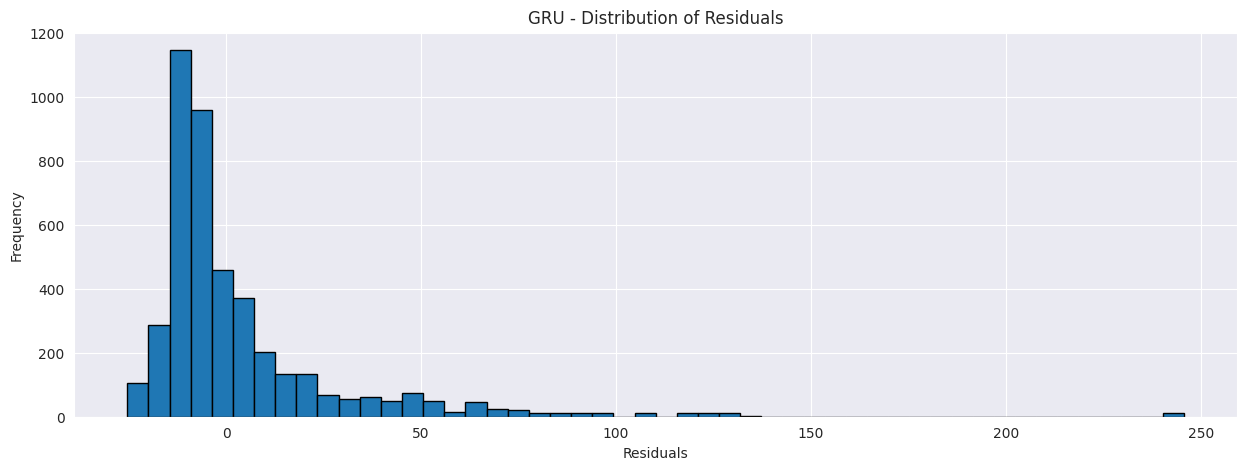

In [132]:
# Analyze residual
residuals_gru = y_val_original - predictions_gru_original

plot_residuals(residuals_gru, "GRU")

In [133]:
perform_breusch_pagan_test(predictions_gru_original, residuals_bilstm)

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 11.340947805048646
P-value: 0.0007581661956346687

Heteroscedasticity detected! The variance of the residual, or error term, in the regression model is not constant.


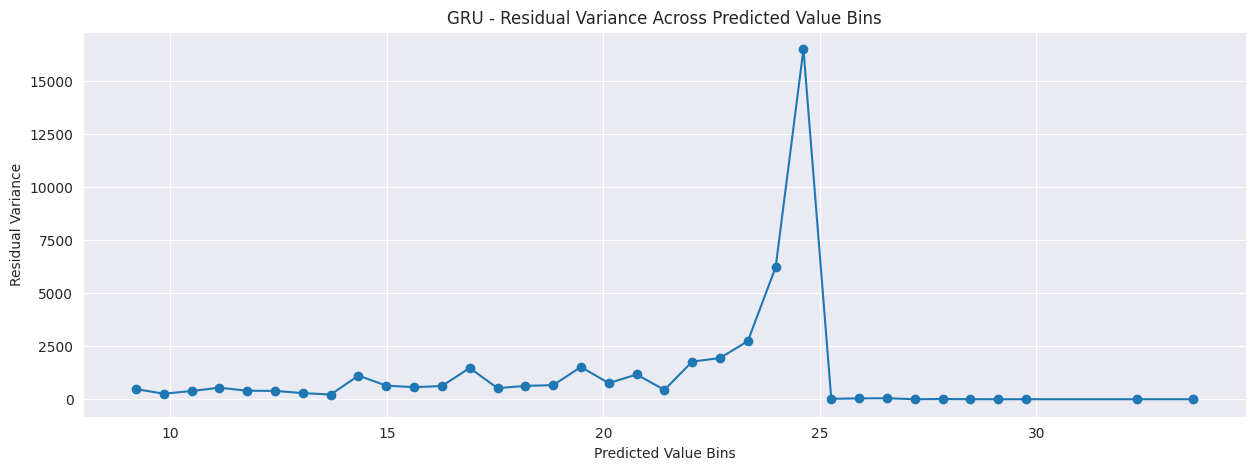

In [134]:
plot_residual_variance_across_prediction(predictions_gru_original, residuals_gru, "GRU")

# Tunning the Best Model : Bi-LSTM

In [135]:
from keras_tuner.tuners import BayesianOptimization

In [136]:
# Define hyperparameters
MAX_EPOCHS = 2000
PATIENCE = 10

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])


In [137]:
# Define build model function for Keras Tuner
def build_bilstm_model(hp):
    batch_size = hp.Int('batch_size', min_value=8, max_value=128, step=8)
    model = tf.keras.models.Sequential()
    
    # Input layer
    model.add(tf.keras.Input(shape=INPUT_SHAPE))  # INPUT_SHAPE = (m timesteps, n features per timestep)
    
    # Add Bidirectional LSTM layers with forced return_sequences=True
    num_bilstm_layers = hp.Int('num_bilstm_layers', 1, 2)  # Tune number of Bi-LSTM layers
    for i in range(num_bilstm_layers):
        model.add(
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(
                    units=hp.Int('units', min_value=8, max_value=512, step=8),  # Tune hidden units
                    activation=hp.Choice(
                        'activation',
                        values=['relu', 'sigmoid', 'tanh'],
                        default='tanh'
                    ),  # Tune activation
                    return_sequences=True  # Force return_sequences=True for all layers
                )
            )
        )
        # Optional Dropout
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))  # Tune dropout rate

    # Output layer
    model.add(tf.keras.layers.Dense(units=1))  # Regression output
    
    # Choose optimizer and learning rate
    optimizer_choice = hp.Choice(
        'optimizer',
        values=['Adam', 'SGD', 'RMSprop']
    )
    if optimizer_choice == 'Adam':
        optimizer = tf.keras.optimizers.Adam(hp.Float('adam_lr', min_value=1e-5, max_value=1e-2, sampling='log'))
    elif optimizer_choice == 'SGD':
        optimizer = tf.keras.optimizers.SGD(hp.Float('sgd_lr', min_value=1e-5, max_value=1e-2, sampling='log'))
    elif optimizer_choice == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(hp.Float('rms_lr', min_value=1e-5, max_value=1e-2, sampling='log'))

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error for regression
        metrics=['mse']) # [r2, me, mse, mae, rmse, mape, mpe]
    
    return model


# Bayesian Optimization Tuner setup
bilstm_tuner = BayesianOptimization(build_bilstm_model,
                                    objective='val_mse',  
                                    max_trials=15,  
                                    executions_per_trial=1,  
                                    directory='bilstm_tuning',
                                    project_name='bilstm_best_hyperparameters',
                                    overwrite=True)

# Perform hyperparameter search
bilstm_tuner.search(X_train, y_train,  
                    epochs=30,  
                    validation_split=0.2,  
                    verbose=1)

Trial 15 Complete [00h 06m 54s]
val_mse: 4.796462059020996

Best val_mse So Far: 0.621168851852417
Total elapsed time: 00h 57m 38s


In [138]:
# Retrieve the best hyperparameters
best_hps = bilstm_tuner.get_best_hyperparameters(num_trials=1)[0]

# Display all the best hyperparameters
for hp_name in best_hps.values:
    print(f"{hp_name}: {best_hps.get(hp_name)}")

batch_size: 64
num_bilstm_layers: 2
units: 24
activation: relu
dropout_rate: 0.4
optimizer: RMSprop
adam_lr: 5.422685137542933e-05
sgd_lr: 0.00011621982295156638
rms_lr: 0.0008156636719686747


In [139]:
# Build the best model with the best hyperparameters
best_bilstm_model = build_bilstm_model(best_hps)

# Compile the best model
best_bilstm_model.compile(optimizer=best_bilstm_model.optimizer, 
                          loss='mse',  # Loss function for regression
                          metrics=[r2, me, 'mse', 'mae', rmse, mape, mpe])

In [140]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=PATIENCE,
                                                      restore_best_weights=True,
                                                      mode='min')

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.3, 
                                                        patience=2, 
                                                        min_lr=1e-6)

# Training
history_best_bilstm = best_bilstm_model.fit(X_train, y_train,
                                            epochs=MAX_EPOCHS,
                                            batch_size=best_hps['batch_size'], 
                                            validation_data=(X_val, y_val),
                                            callbacks=[early_stopping, lr_scheduler],
                                            verbose=1)

Epoch 1/2000


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 5.8399 - mae: 0.9234 - mape: 6274864.5000 - me: 0.5039 - mpe: -6266220.5000 - mse: 5.8399 - r2: 0.0380 - rmse: 2.2943 - val_loss: 2.0063 - val_mae: 0.8358 - val_mape: 21313364.0000 - val_me: 0.1520 - val_mpe: -21313000.0000 - val_mse: 2.0063 - val_r2: 0.1435 - val_rmse: 1.4242 - learning_rate: 8.1566e-04
Epoch 2/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 4.4135 - mae: 0.9617 - mape: 18503436.0000 - me: 0.0615 - mpe: -18501348.0000 - mse: 4.4135 - r2: 0.2400 - rmse: 2.0135 - val_loss: 1.8454 - val_mae: 0.8134 - val_mape: 23184026.0000 - val_me: 0.0961 - val_mpe: -23183662.0000 - val_mse: 1.8454 - val_r2: 0.2117 - val_rmse: 1.3655 - learning_rate: 8.1566e-04
Epoch 3/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.0612 - mae: 0.9141 - mape: 19043890.0000 - me: 0.0421 - mpe: -18937446.0000 - mse: 4.0612 - r2: 0.2861 - rmse: 1.9446 - val_loss: 1.6935 - val_mae: 0.7811 - val_mape: 23795246.0000 - val_me: 0.0754 - val_mpe: -232

In [141]:
# Evaluation

val_evaluations = {}
evaluations = {}

val_evaluations['Best-Bi-LSTM'] = best_bilstm_model.evaluate(X_val, y_val, verbose=1, return_dict=True)
evaluations['Best-Bi-LSTM'] = best_bilstm_model.evaluate(X_test, y_test, verbose=0, return_dict=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3308 - mae: 0.3265 - mape: 6267605.0000 - me: 0.1134 - mpe: -4032267.7500 - mse: 0.3308 - r2: 0.8523 - rmse: 0.5610


In [142]:
print("Evaluation on the validation set")
pd.DataFrame(val_evaluations).T

Evaluation on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
Best-Bi-LSTM,0.327332,0.332126,6979887.5,0.113208,-4588427.0,0.327332,0.854285,0.555257


In [143]:
print("Evaluation on the test set")
pd.DataFrame(evaluations).T

Evaluation on the test set


,loss,mae,mape,me,mpe,mse,r2,rmse
Best-Bi-LSTM,0.258791,0.330406,6447477.0,0.155894,-4148125.0,0.258791,0.827269,0.502153


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step


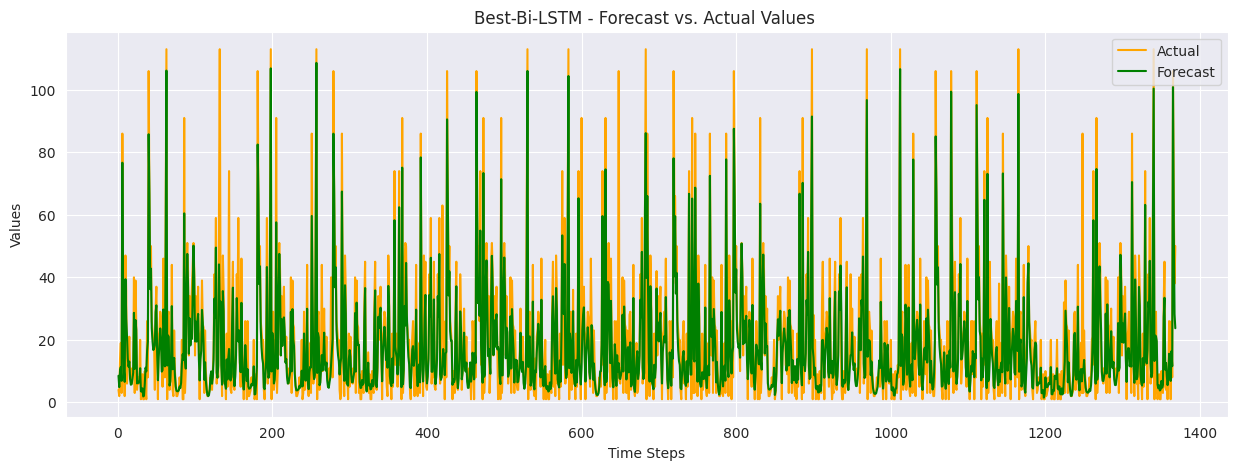

In [144]:
# Make predictions on the validation dataset
predictions_best_bilstm = best_bilstm_model.predict(X_test) 

""" Forecasting accuracy across all time steps """ 

# Reshape the true labels and the prediction
y_test_reshape = y_test.reshape(-1, 1) 
# # Extract the corresponding true labels (last time step for each sequence)
# y_test_single_step = y_test[:, -1, :]  # Shape: (65, 1)
predictions_best_bilstm_reshape = predictions_best_bilstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_best_bilstm_original = scaler.inverse_transform(predictions_best_bilstm_reshape)
y_test_original = scaler.inverse_transform(y_test_reshape)

# # Plot the predictions against the true labels
plot_forecast(y_test_original, predictions_best_bilstm_original, "Best-Bi-LSTM")

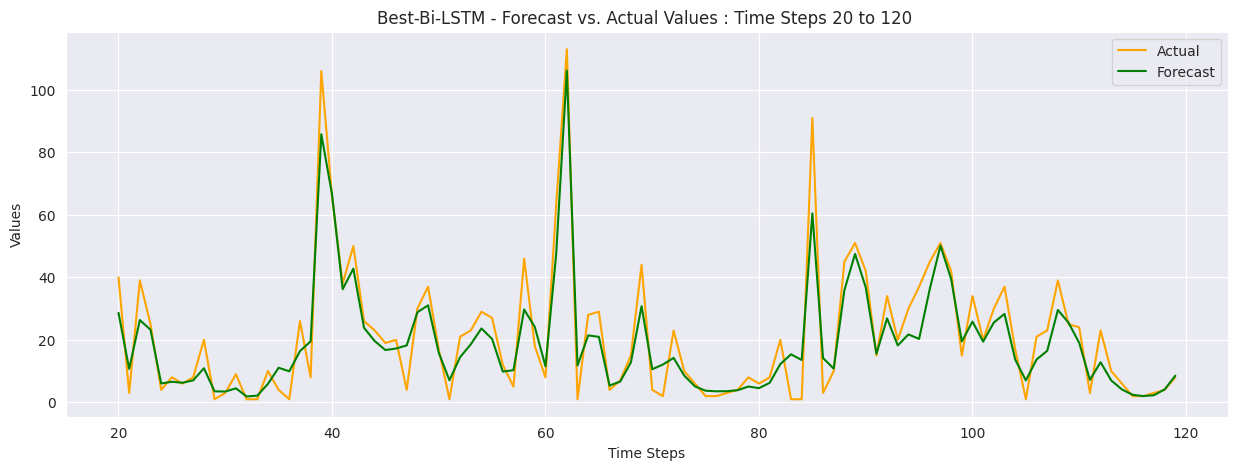

In [145]:
plot_zoomed_forecast(y_test_original, predictions_best_bilstm_original, 20, 120, "Best-Bi-LSTM") 

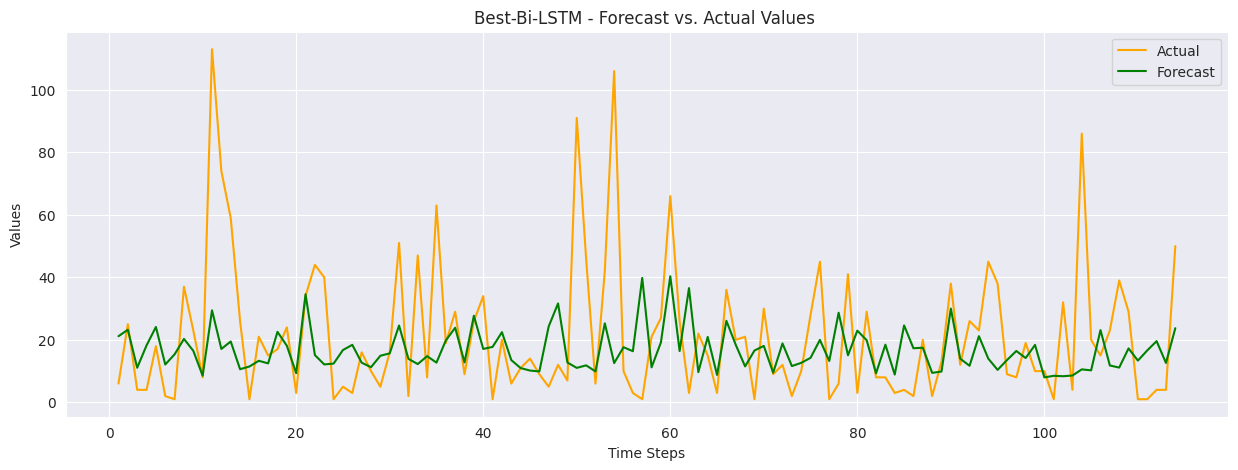

In [146]:
""" Forecasting for the last time step """
# Extract the corresponding true labels (last time step for each sequence)
y_test_single_step = y_test[:, -1, :]  
predictions_best_bilstm_single_step = predictions_best_bilstm[:, -1, :] 

# Apply inverse transformation 
predictions_best_bilstm_original = scaler.inverse_transform(predictions_best_bilstm_single_step)
y_test_original = scaler.inverse_transform(y_test_single_step)

# # Plot the predictions against the true labels
plot_forecast(y_test_original, predictions_best_bilstm_original, "Best-Bi-LSTM")